In [ ]:
import re
import os
import shutil
import datetime
import gc
import nltk
import pickle
import codecs
import warnings
warnings.filterwarnings("ignore")
import scipy
from scipy import sparse
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid')
from sklearn import preprocessing
from collections import Counter
import string
from nltk.corpus import stopwords
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM,Lambda
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [ ]:
train = pd.read_csv('train.csv').fillna('') #there is one null value,replace it with ''
test = pd.read_csv('test.csv')
train.shape,test.shape

((27481, 4), (3534, 3))

Let's try some approaches and build a base line model.

Performance Metric:

In [ ]:
def jaccard(str1, str2): #function for finding jaccard similarity for given two sentences
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## Naive Model

Let's take naive approach: take given text as it is for predictions.

In [ ]:
train['naive'] =  train['text']
train.head()

,textID,text,selected_text,sentiment,naive
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on t..."


In [ ]:
js=0
for i in range(train.shape[0]):
  if i!=314: #as there is an null value and we replaced it with '',it will give zero length for sentence and raises zero error,so neglect that one sentence
    js = js + jaccard(train.iloc[i,2],train.iloc[i,4])
print("final jaccard score for naive predictions:",js/(train.shape[0]))

final jaccard score for naive predictions: 0.5890549523414182


We can take this score as baseline score for comparing other model's performances.

# Siamese Network Model(to be modified)

This is s simple model and We will model this in two steps.
1.Take tweets only with positive and negative sentiments and model these using siamese network.
2.Take neutral tweets and as 90% of the tweets has selected text same as text,let's use the text as it is as selected text for neutral tweets. 

we can model this at word level or character level(word level - taking number of words per sentence to form pairs of sentences; charcter level - taking the number of characters per sentence to form pairs of sentences). Tried character level for sample of sentences,performance is improved,but it's not significant and also,we are getting meaning less selected text from the text as we do character level.So let's compromise small improvement for interpretability and use word level model here.

In [ ]:
p = train.loc[train['sentiment']!='neutral'] #take only positive and negative tweets
p.head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive


In [ ]:
p['stext_ln'] = p['selected_text'].str.split().apply(len) #calculate sub text number of words and text number of words per tweet and add these as columns.(if we want to model this at character level, then don't split the sentence and take length directly which gives number of characters per sentence)
p['text_ln'] = p['text'].str.split().apply(len)
p.head()

,textID,text,selected_text,sentiment,stext_ln,text_ln
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2,10
2,088c60f138,my boss is bullying me...,bullying me,negative,2,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,3,14
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,1,14


for using siamese network,data should be in pairs,so let's take each sentence and select some parts of that sentence and add them as new column.Now,how to select these sub texts from each sentence?For this,we will take the unique number of lengths of all sentences and for each text length value,we take all the selected texts corresponding to this text length and take the sub text length which appears 60% of the times for this text length.(this 60% is parameter we have to find the best number which gives us best mertic score).

In [ ]:
f = p.groupby('text_ln') #group by text_length 
d={}
for i in range(1,len(f.text_ln.unique())+1): #for each text length value:
  g=f.get_group(i) #get all the rows with that text length
  c = int(np.percentile(g['stext_ln'].values,60)) #find the 60th percentile value of selected text length for this text length
  d[i] = c #dictionary--> text length:selected text length
print(d)

{1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4, 22: 3, 23: 3, 24: 3, 25: 4, 26: 3, 27: 3, 28: 4, 29: 4, 30: 5, 31: 5, 32: 4, 33: 5}


In [ ]:
#f.get_group(25)#view a sample group

Let's create pairs of sentences for eaxh text sentence,we take the above dictionary values and divide each text based on these 60% select text length values.

For example: if a given sentence is : my boss is bullying me. we find the text length of this and corresponding truncating selected text length(which is 60% of the maximum selected text lengths) from the dictionary.

Here text length means: number of words per sentence

Text length : 5;  Truncated selected text length : 3 (from the dictionary)

So we take all the 3 grams of these sentence and form new pairs with this text.

As the model needs labels to train,we have to label these pairs.So we take similarity of each pair and label the pair  the maximum similarity as 1 and rest as 0.(if multiple pairs have maximum similarity,then take the first pair: this is also like a paramerter we can try labelling the last pair as 1 or take random pair from all the maximum similarity pairs and label it as 1 ).

In [ ]:
import re
from nltk.util import ngrams
#function fro getting pairs for each given text and labelling these pairs as per similarity score.
def select_text(p,d):
  df = pd.DataFrame()
  for i in range(p.shape[0]):
    op = p.iloc[i,2]
    l = d[p.iloc[i,5]]
    #print(p.iloc[i,2])
    s = p.iloc[i,1]
    s = s.lower()
    #s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    tokens = [token for token in s.split(" ") if token != ""]
    output = list(ngrams(tokens, l)) #take n grams of the sentence and take these as pairs
    new=[]
    for i in output: #join the ngram words to from a sentence
      k = " ".join(i)
      new.append(k) #selected parts of sentences
    op_len = len(new)
    tot=[]
    for i in range(op_len):
      tot.append(s) #create a same text file for all the newly extracted sub texts so that they all from pairs : (text,selected text)
    sim=[]
    for i in new:
      sim.append(jaccard(i,op)) #find jaccard scores for all the pairs
    mx = np.argmax(sim) #select the maximum jaccard score pair(note: this selects the first pair as maximum score pair if we have multiple pairs which give maximum scores)
    y_op=[]
    for i in range(op_len): #labelling the maximum score pair as 1 and rest as 0
      if i==mx:
        y_op.append(1)
      else:
        y_op.append(0)
    list_of_tuples = list(zip(tot, new,y_op)) 
    fd = pd.DataFrame(list_of_tuples,columns = ['text', 'selected','label'] ) #creating new dataframe
    df = df.append(fd,ignore_index=True)
  return df

In [ ]:
df = select_text(p,d)
df.head()

,text,selected,label
0,sooo sad i will miss you here in san diego!!!,sooo sad i,1
1,sooo sad i will miss you here in san diego!!!,sad i will,0
2,sooo sad i will miss you here in san diego!!!,i will miss,0
3,sooo sad i will miss you here in san diego!!!,will miss you,0
4,sooo sad i will miss you here in san diego!!!,miss you here,0


In [ ]:
df.shape

(183842, 3)

Now that we have got our train data and labels,instead of using LSTM/CNN for getting sentence embeddings,let's use pretrained glove vectors for words and use tfidf weighted word2vec as sentence representations and use a simple forward neural network to train the model.we take 300 dimensional representations of each word.

As data is very less and there are multiple pairs of sentences for each given text,let's not divide train data further for cross validation and use all the available data for training.

Download and extract the glove vectors:

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fcompressed%2Fglove.42B.300d.txt.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1598246009&Signature=WVUmdbmP5YJkY8%2FQXW%2FT%2FHKAv%2BBg8UEvdZkWsYEScVewADaVfTYilPWRkrixk7ULcbVl%2BFjnRTmCpRgBnhhMJnVJ4LPZHktinWeVsn8upiTkPZNwZ%2FGDVCWNFELfNdi9KjjZ7n92SgX8pYkh2Q0bQhsqJUrBLGTRmCtYkQAhCOjCR2h3jnmYtZDCjhJoHOpR%2FdYeW%2FudJNL5ons4h%2B1j3NFRp1QtxtD8GJftH08tb4UJdlCvJQTOg46EWdAaVqhnMVfw8oQPyoaSu36%2BEummYcEz7BuWPB3hZy%2Fv3Y0T9Yb%2BflQUPBtFO09Yfeauj5S%2BqSrsEMATH8o3u4HSb2otIw%3D%3D" -c -O '213609_464671_compressed_glove.42B.300d.txt.zip'

--2020-08-21 05:14:02--  https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fcompressed%2Fglove.42B.300d.txt.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1598246009&Signature=WVUmdbmP5YJkY8%2FQXW%2FT%2FHKAv%2BBg8UEvdZkWsYEScVewADaVfTYilPWRkrixk7ULcbVl%2BFjnRTmCpRgBnhhMJnVJ4LPZHktinWeVsn8upiTkPZNwZ%2FGDVCWNFELfNdi9KjjZ7n92SgX8pYkh2Q0bQhsqJUrBLGTRmCtYkQAhCOjCR2h3jnmYtZDCjhJoHOpR%2FdYeW%2FudJNL5ons4h%2B1j3NFRp1QtxtD8GJftH08tb4UJdlCvJQTOg46EWdAaVqhnMVfw8oQPyoaSu36%2BEummYcEz7BuWPB3hZy%2Fv3Y0T9Yb%2BflQUPBtFO09Yfeauj5S%2BqSrsEMATH8o3u4HSb2otIw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928408067 (1.8G) [application/zip]
Saving to: ‘213609_464671_compressed_glove.42B.300d.txt.zip’

213609_464671_compr 100%[==========

In [ ]:
from zipfile import ZipFile #unzipping the file as downloaded file is in zip format
file_name= "213609_464671_compressed_glove.42B.300d.txt.zip"
with ZipFile(file_name, 'r') as zp:
 zp.extractall()

In [ ]:
from tqdm import tqdm
#import numpy as np
def loadGloveModel(gloveFile):
   # loading the glove model vectors
  print ("Loading Glove Model")
  f = open(gloveFile,'r', encoding="utf8")
  model_g = {}
  for line in tqdm(f):
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model_g[word] = embedding
  print("Done.",len(model_g)," words loaded!")
  return model_g
model_g = loadGloveModel('glove.42B.300d.txt')

1834it [00:00, 9287.78it/s]

Loading Glove Model


1917494it [03:42, 8610.66it/s]

Done. 1917494  words loaded!


tfidf w2vec

In [ ]:
def get_tfidf(df,model_g): #function for getting tfidf values and glove vectors
  words = []
  for i in df['text']:
    words.extend(i.split(' '))
  #print("all the words in the coupus", len(words))
  words = set(words)
  #print("the unique words in the coupus", len(words))
  inter_words = set(model_g.keys()).intersection(words)
  #print("The number of words that are present in both glove vectors and our coupus", len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

  words_courpus = {}
  words_glove = set(model_g.keys())
  for i in words:
    if i in words_glove:
      words_courpus[i] = model_g[i]
  #print("word 2 vec length", len(words_courpus))
  glove_words = set(words_courpus.keys()) #all the unique words in the text column

  tfidf_model = TfidfVectorizer()
  tfidf_model.fit(df['text'])
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
  tfidf_words = set(tfidf_model.get_feature_names())
  
  return glove_words,dictionary,tfidf_words

In [ ]:
glove_words,dictionary,tfidf_words = get_tfidf(df,model_g)

all the words in the coupus 3361466
the unique words in the coupus 31184
The number of words that are present in both glove vectors and our coupus 15560 ( 49.897 %)
word 2 vec length 15560


final data

In [ ]:
def get_final_train_data(df,model_g,glove_words,dictionary,tfidf_words):

  X_train_tfidf_w2v = []; # the avg-w2v for each sentence is stored in this list
  for sentence in tqdm(df['text']): # for each sentence
  #for sentence in df['text']:
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence
      for word in sentence.split(): # for each word in a sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model_g[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      X_train_tfidf_w2v.append(vector)

  print(len(X_train_tfidf_w2v))
  print(len(X_train_tfidf_w2v[0]))

  X_test_tfidf_w2v = []; # the avg-w2v for each sentence is stored in this list
  for sentence in tqdm(df['selected']): # for each sentence
  #for sentence in df['selected']:
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence
      for word in sentence.split(): # for each word in a sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model_g[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      X_test_tfidf_w2v.append(vector)

  print(len(X_test_tfidf_w2v))
  print(len(X_test_tfidf_w2v[0]))
  

  X_train1 = np.asarray(X_train_tfidf_w2v)
  X_train2 = np.asarray(X_test_tfidf_w2v)
  

  return X_train1,X_train2 #return final text and selected text pairs representations

In [ ]:
X_train1,X_train2 = get_final_train_data(df,model_g,glove_words,dictionary,tfidf_words)
y = df['label'] #output labels

  2%|▏         | 3450/183842 [00:00<00:05, 34496.09it/s]

183842
300


100%|██████████| 183842/183842 [00:05<00:00, 34820.47it/s]


183842
300


Training

In [ ]:
left_input = Input(shape=(300,))
right_input = Input(shape=(300,))
model = Sequential()
model.add(Dense(4096,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001)))

# Generate the encodings (feature vectors) for the two sentences
encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings(similarity = 1-distance)
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
siamese_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         1232896     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

In [ ]:
%load_ext tensorboard
import datetime
!!rm -rf ./logs/  #clear ant previous logs
optimizer = optimizers.Adam()
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
history = siamese_net.fit([X_train1,X_train2],y,batch_size=256,epochs=10,verbose=1,callbacks=tensorboard_callback)

Epoch 1/10
  1/719 [..............................] - ETA: 0s - loss: 10.5464WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
719/719 [==============================] - 6s 8ms/step - loss: 0.9307
Epoch 2/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3050
Epoch 3/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3007
Epoch 4/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3011
Epoch 5/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3021
Epoch 6/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3009
Epoch 7/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3016
Epoch 8/10
719/719 [==============================] - 5s 8ms/step - loss: 0.3023
Epoch 9/

In [ ]:
%tensorboard --logdir logs/fit

## Predictions and calculating Jaccard score for train data

In [ ]:
pred = siamese_net.predict([X_train1,X_train2]) #predictions
df['final'] =  pred #add predictions to the initial dataframe
df.head()

,text,selected,label,final
0,sooo sad i will miss you here in san diego!!!,sooo sad i,1,0.096611
1,sooo sad i will miss you here in san diego!!!,sad i will,0,0.048661
2,sooo sad i will miss you here in san diego!!!,i will miss,0,0.016462
3,sooo sad i will miss you here in san diego!!!,will miss you,0,0.012329
4,sooo sad i will miss you here in san diego!!!,miss you here,0,0.013085


In [ ]:
txt = df.groupby('text') #group by text and finding the final selected text which was given highest value in predictions
final =[]
for i in p['text']:
  i=i.lower()
  g = txt.get_group(i)
  mx = np.argmax(g['final'])
  f_p = g.iloc[mx]['selected']
  final.append(f_p) #final selected text for each text

In [ ]:
p['final'] =  final
p.head()


,textID,text,selected_text,sentiment,stext_ln,text_ln,final
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2,10,sooo sad i
2,088c60f138,my boss is bullying me...,bullying me,negative,2,5,boss is bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3,5,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,3,14,"of ****, why"
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,1,14,is all smiles


In [ ]:
js=0
for i in range(p.shape[0]):
  js = js + jaccard(p.iloc[i,2],p.iloc[i,6])
print("final jaccard score for positive and negative tweets:",js/(p.shape[0]))

final jaccard score for positive and negative tweets: 0.30274505677367824


## Predictions on test data

In [ ]:
p_test = test.loc[test['sentiment']!='neutral'] #take only positive and negative tweets
p_test['text_ln'] = p_test['text'].str.split().apply(len)
p_test.head()

,textID,text,sentiment,text_ln
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5
5,726e501993,that`s great!! weee!! visitors!,positive,4


In [ ]:
import re
from nltk.util import ngrams

def select_test_text(p,d):
  df = pd.DataFrame()
  for i in range(p.shape[0]):
    l = d.get(p.iloc[i,3],0) #get the selected text length corresponding to the text length of train data,if not there, return 0
    #print(p.iloc[i,2])
    s = p.iloc[i,1]
    s = s.lower()
    #s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    tokens = [token for token in s.split(" ") if token != ""]
    if l==0: #if the length of sentence is not in train length just make that as output else form ngrams
      output = tokens
    else:
      output = list(ngrams(tokens, l))
    new=[]
    for i in output:
      k = " ".join(i)
      new.append(k)
    op_len = len(new)
    tot=[]
    for i in range(op_len):
      tot.append(s)
    list_of_tuples = list(zip(tot, new)) 
    fd = pd.DataFrame(list_of_tuples,columns = ['text', 'selected'] )
    df = df.append(fd,ignore_index=True)
  return df

In [ ]:
df_test = select_test_text(p_test,d)
df_test.head()

,text,selected
0,shanghai is also really exciting (precisely -...,shanghai is also
1,shanghai is also really exciting (precisely -...,is also really
2,shanghai is also really exciting (precisely -...,also really exciting
3,shanghai is also really exciting (precisely -...,really exciting (precisely
4,shanghai is also really exciting (precisely -...,exciting (precisely --


In [ ]:
df_test.shape

(23029, 2)

In [ ]:
#glove_words_t,dictionary_t,tfidf_words_t = get_tfidf(df_test,model_g)
X_test1,X_test2 = get_final_train_data(df_test,model_g,glove_words,dictionary,tfidf_words) #using the glove words,dictionary and tfidf_words of train data so that there is no data leakage

 19%|█▉        | 4348/23029 [00:00<00:00, 43296.81it/s]

23029
300


100%|██████████| 23029/23029 [00:00<00:00, 38405.22it/s]


23029
300


In [ ]:
pred_test = siamese_net.predict([X_test1,X_test2])
df_test['final'] =  pred_test
df_test.head()

,text,selected,final
0,shanghai is also really exciting (precisely -...,shanghai is also,0.006350
1,shanghai is also really exciting (precisely -...,is also really,0.014882
2,shanghai is also really exciting (precisely -...,also really exciting,0.022880
3,shanghai is also really exciting (precisely -...,really exciting (precisely,0.019521
4,shanghai is also really exciting (precisely -...,exciting (precisely --,0.009451


In [ ]:
txt = df_test.groupby('text')
final =[]
for i in p_test['text']:
  i=i.lower()
  g = txt.get_group(i)
  mx = np.argmax(g['final'])
  f_p = g.iloc[mx]['selected']
  final.append(f_p)

In [ ]:
p_test['final'] =  final

In [ ]:
p_test.head() #final test dataframe with predictions in final column

,textID,text,sentiment,text_ln,final
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15,skyscrapers galore). good
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13,recession hit veronique
3,01082688c6,happy bday!,positive,2,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5,- i like
5,726e501993,that`s great!! weee!! visitors!,positive,4,that`s great!! weee!!


## Neutral Tweets

Lets use neutral tweets text as it is for selected text:

In [ ]:
n = train.loc[train['sentiment']=='neutral']
n.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral


In [ ]:
n['final'] = n['text']
n.head()

,textID,text,selected_text,sentiment,final
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...
7,50e14c0bb8,Soooo high,Soooo high,neutral,Soooo high
8,e050245fbd,Both of you,Both of you,neutral,Both of you
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,"as much as i love to be hopeful, i reckon the..."


In [ ]:
js=0
for i in range(n.shape[0]):
  js = js + jaccard(n.iloc[i,2],n.iloc[i,4])
print("jaccard score for neutral tweets:",js/(n.shape[0]))

jaccard score for neutral tweets: 0.9764446695277987


In [ ]:
print("final jaccard score for train data:,",(0.97+0.31)/2)

final jaccard score for train data:, 0.64


**Observation:**we can see that this model performance is better than our naive predictions.

### Neutral Tweets for Test data

In [ ]:
n_test = test.loc[test['sentiment']=='neutral']
n_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
8,e64208b4ef,and within a short time of the last clue all ...,neutral
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral
11,43b390b336,I checked. We didn`t win,neutral
12,69d6b5d93e,.. and you`re on twitter! Did the tavern bore...,neutral


In [ ]:
n_test['final'] = n_test['text']
n_test.head()

,textID,text,sentiment,final
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`...
11,43b390b336,I checked. We didn`t win,neutral,I checked. We didn`t win
12,69d6b5d93e,.. and you`re on twitter! Did the tavern bore...,neutral,.. and you`re on twitter! Did the tavern bore...


In [ ]:
final_test = p_test.append(n_test) #merging all the final predictions of all the tweets
final_test = final_test.sort_index(ascending=True)
final_test.head()

,textID,text,sentiment,text_ln,final
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,NaN,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15.0,really exciting (precisely
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13.0,recession hit veronique
3,01082688c6,happy bday!,positive,2.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5.0,- i like


In [ ]:
sub = final_test[['textID','final']]
sub.head()

,textID,final
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,really exciting (precisely
2,eee518ae67,recession hit veronique
3,01082688c6,happy bday!
4,33987a8ee5,- i like


In [ ]:
sub.to_csv('submission.csv',index=False)

**Observation:** We got 0.64 as jaccard score for the train tweets using this siamese network model.After submitting these test predictions to kaggle,i got 0.58 score for test data,which indicates that this simple model is performing well and model is slightly overfitting.

As we have already seen in EDA, that contextual information may play good role in the predictions,from the above model,using word to vectors of glove is yielding good results,so let's extend this by using RNN's to capture sequence information in the given text and see if predictions improve.


#LSTM Model on word level

Here we have two inputs for the model: 
1.categorical data - sentiment of the tweet
2.text data - tweet

Here we take all the data at once instead of modelling separately for neutral and non neutral tweets.As data is less,let's take 10% of data for cross validation.

In [ ]:
from sklearn.model_selection import train_test_split #split train and cv data
x_train,x_cv,y_train,y_cv=train_test_split(train,train.sentiment,test_size=0.10,stratify=train.sentiment) #split wrt sentiment so that their distribution is equal in cv and train data
x_train.shape,x_cv.shape #train and cv data shapes

((24732, 4), (2748, 4))


Label encoding of sentiment variable

In [ ]:
from sklearn import preprocessing
vectorizer = preprocessing.LabelEncoder() #encoding school state: train and test values
vectorizer.fit(x_train['sentiment'].values)
train_sent = vectorizer.transform(x_train['sentiment'].values)
cv_sent = vectorizer.transform(x_cv['sentiment'].values)
test_sent = vectorizer.transform(test['sentiment'].values)
print("After Label encoding")
print(train_sent.shape)
print(cv_sent.shape)
print(test_sent.shape)

After Label encoding
(24732,)
(2749,)
(3534,)


In [ ]:
MAX_SEQUENCE_LENGTH = max(x_train['text'].str.split().apply(len)) #maximum length of the sequence(maximum number of words for given sentence)
MAX_SEQUENCE_LENGTH

33

## Tokenizing with cleaning

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenizing and padding
tokenizer = Tokenizer() #removing all the special symbols
tokenizer.fit_on_texts(x_train['text'].values)
X_train_sequences = tokenizer.texts_to_sequences(x_train['text'].values)
X_cv_sequences   =  tokenizer.texts_to_sequences(x_cv['text'].values)
X_test_sequences = tokenizer.texts_to_sequences(test['text'].values)

# return list with each element having word index numbers like : for 3 sentences in final,sequences : [1, 2, 2, 5, 6], [7, 3, 8, 4, 3, 9], [10, 11, 1, 4, 12]
word_index = tokenizer.word_index
print("unique words in train data : {}".format(len(word_index)))
#padding to 33 words
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #pre padding upto maximum number of words:33
X_cv_pad = pad_sequences(X_cv_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train tensor:',X_train_pad.shape)
print('Shape of cv tensor:',X_cv_pad.shape)
print('Shape of test tensor:',X_test_pad.shape)

unique words in train data : 24962
Shape of train tensor: (24732, 33)
Shape of cv tensor: (2749, 33)
Shape of test tensor: (3534, 33)


In [ ]:
#padding selected text:this will be used in getting start and end token values and there by extracting the target labels
X_train_sel = tokenizer.texts_to_sequences(x_train['selected_text'].values) 
X_train_sel_pad = pad_sequences(X_train_sel, maxlen=MAX_SEQUENCE_LENGTH)
X_cv_sel = tokenizer.texts_to_sequences(x_cv['selected_text'].values)
X_cv_sel_pad = pad_sequences(X_cv_sel, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train selected text tensor:',X_train_sel_pad.shape)
print('Shape of cv selected text tensor:',X_cv_sel_pad.shape)

Shape of train selected text tensor: (24732, 33)
Shape of cv selected text tensor: (2749, 33)


In [ ]:
X_train_pad[0] #sample padded value

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     1,    92, 12468], dtype=int32)

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fcompressed%2Fglove.42B.300d.txt.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599287154&Signature=RiGQv4w1THNZcMfyQ7%2FBdTAG6wcfWWDwK22Ile%2BgTTUSW0kwjf0McjXJc1TJeokAstSn1yU3nzSGM%2BzSHQCtCNtAmz1sbHoSgA21pMmhtibTPrLR4LGnyIoHs5BXCyJfoAYmfbLEw1VmajAo2dQ%2B03amraaMCznByPbRtyBacwOjXJ51jXKgpo%2BcjYmOPTnzPWT66c65By7IKcUZc7DKi72ltU8rwcfZYOnFOunu3yo%2F8ndUZYAICo%2FctifOgw%2F2xghNq78sHVwmJNGxn1Ow5gaNjOSqeaHfGRzTcxe3I0rblysN2gyVnozv2LO6wcsg6y1vLVTVeqQRFP6H7jCsGA%3D%3D" -c -O '213609_464671_compressed_glove.42B.300d.txt.zip'

--2020-09-02 06:26:15--  https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fcompressed%2Fglove.42B.300d.txt.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599287154&Signature=RiGQv4w1THNZcMfyQ7%2FBdTAG6wcfWWDwK22Ile%2BgTTUSW0kwjf0McjXJc1TJeokAstSn1yU3nzSGM%2BzSHQCtCNtAmz1sbHoSgA21pMmhtibTPrLR4LGnyIoHs5BXCyJfoAYmfbLEw1VmajAo2dQ%2B03amraaMCznByPbRtyBacwOjXJ51jXKgpo%2BcjYmOPTnzPWT66c65By7IKcUZc7DKi72ltU8rwcfZYOnFOunu3yo%2F8ndUZYAICo%2FctifOgw%2F2xghNq78sHVwmJNGxn1Ow5gaNjOSqeaHfGRzTcxe3I0rblysN2gyVnozv2LO6wcsg6y1vLVTVeqQRFP6H7jCsGA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928408067 (1.8G) [application/zip]
Saving to: ‘213609_464671_compressed_glove.42B.300d.txt.zip’

213609_464671_compr 100%[===================>]   1

In [ ]:
#https://www.kaggle.com/yutanakamura/glove42b300dtxt#glove.42B.300d.txt
#extracting glove vectors file
from zipfile import ZipFile
file_name= "213609_464671_compressed_glove.42B.300d.txt.zip"
with ZipFile(file_name, 'r') as zp:
  zp.extractall()

In [ ]:
#getting vectors in dictionary form
embeddings_index = {}
f = open('glove.42B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
#froming embedded matrix
c=[]
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
 # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  else: #if words dont have vectors in glove,let's observe those words and check whether the tokenizaion is doing good job here are not.
    c.append(word)
#till now, we got embedded matrix with vectors

In [ ]:
embedding_matrix.shape,X_train_pad[0].shape

We have to predict  start and end tokens of a given sentence,so extract the output labels with start and end tokens as 1 and rest as 0.

In [ ]:
#comparing the text and selected texts and extracting the start and end tokens and get the target labels with start and end tokens as 1 and rest as 0
f1=[]
for i in range(x_train.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of start and end tokens as 1 and rest as 0
  flag1=0
  flag2=0
  for j in range(MAX_SEQUENCE_LENGTH):
    if X_train_sel_pad[i][j]!=0 and flag1==0 and X_train_sel_pad[i][j] in X_train_pad[i]: #once the start token is found,mark the values at the index 1
      start=list(X_train_pad[i]).index(X_train_sel_pad[i][j])
      #print("s",start)
      t[start]=1
      flag1=1
  f1.append(t)
y_train1 = np.array(f1)
      
f2=[]
for i in range(x_train.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of start and end tokens as 1 and rest as 0
  flag1=0
  flag2=0
  for j in range(MAX_SEQUENCE_LENGTH):
    if X_train_sel_pad[i][::-1][j]!=0 and flag2==0 and X_train_sel_pad[i][::-1][j] in X_train_pad[i]  : #once end token is found,mark the values at the index 1
      #end=list(X_train_pad[i]).index(X_train_sel_pad[i][::-1][j])
      #print(MAX_SEQUENCE_LENGTH-1-j)
      t[MAX_SEQUENCE_LENGTH-1-j]=1 #there may be multiple values so if we take .index(),u will only get the first index where the value is present
      flag2=1
  f2.append(t)
y_train2 = np.array(f2) #final array of target labels
y_train1.shape,y_train2.shape

((24732, 33), (24732, 33))

In [ ]:
print(X_train_pad[581])
print(X_train_sel_pad[581])
print(f1[581])
print(f2[581])

In [ ]:
f3=[] #doing the same as above for cv data
for i in range(x_cv.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH
  flag1=0
  flag2=0
  for j in range(MAX_SEQUENCE_LENGTH):
    if X_cv_sel_pad[i][j]!=0 and flag1==0 and X_cv_sel_pad[i][j] in X_cv_pad[i]:
      start=list(X_cv_pad[i]).index(X_cv_sel_pad[i][j])
      #print(start)
      t[start]=1
      flag1=1
  f3.append(t)
y_cv1 = np.array(f3)

f4=[] #doing the same as above for cv data
for i in range(x_cv.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH
  flag1=0
  flag2=0
  for j in range(MAX_SEQUENCE_LENGTH):     
    if X_cv_sel_pad[i][::-1][j]!=0 and flag2==0 and X_cv_sel_pad[i][::-1][j] in X_cv_pad[i]  :
      #end=list(X_cv_pad[i]).index(X_cv_sel_pad[i][::-1][j])
      #print(end)
      t[MAX_SEQUENCE_LENGTH-1-j]=1
      flag2=1
  f4.append(t)
y_cv2 = np.array(f4)
y_cv1.shape,y_cv2.shape

((2749, 33), (2749, 33))

Here for each input, we have 2 outputs.This is a multi label classification problem.There are different ways to model a multi label classification problem.Refer below links for some of the methods.
http://scikit.ml/api/skmultilearn.html#module-skmultilearn.adapt
https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

Let's train it as a two separate binary classifications,but there is correlation between the two labels(i.e. end token prediction is influenced by start token),so instead of choosing two models, let's train it with one model with multiple outputs.
Refer below link for multi output classification in keras:
https://sanjayasubedi.com.np/deeplearning/multioutput-keras/

If we are using label powerset for multilabel classifications,make sure that train and cv data has equal distributions of output variable,so that new labels won't appear in cv data which are not in train data.



In [ ]:
#building model
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
emb_text = embedding_layer = Embedding(len(word_index)+1, #embedding layer with glove vectors as embeddings
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,mask_zero=True)(text_input)    #masking the input values with mask_zero= True
lstm_out = LSTM(128,return_sequences=True,kernel_regularizer=regularizers.l2(0.001),)(emb_text) #lstm
flatten1=Flatten()(lstm_out)

senti_input=Input(shape=(1,), name='sentiment_input')
emb_st = Embedding(output_dim=2, input_dim=4)(senti_input) #embedding layer for categorical data
flatten2=Flatten()(emb_st)

x_con = concatenate([flatten1,flatten2])

x1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_con) #dense layers with drop outs and batch normalisation
x1=Dropout(0.5)(x1)
x1 =BatchNormalization()(x1)
x1 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x1)

output1 = Dense(MAX_SEQUENCE_LENGTH, activation='softmax', name='output1')(x1)


x2 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_con) #dense layers with drop outs and batch normalisation
x2=Dropout(0.5)(x2)
x2 =BatchNormalization()(x2)
x2 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x2)

output2 = Dense(MAX_SEQUENCE_LENGTH, activation='softmax', name='output2')(x2)

model1 = Model(inputs=[text_input,senti_input], outputs=[output1,output2])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

lr_red = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto',min_delta=0.000001)

In [ ]:
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      7496700     text_input[0][0]                 
__________________________________________________________________________________________________
sentiment_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 33, 128)      219648      embedding[0][0]                  
_______________________________________________________________________________________

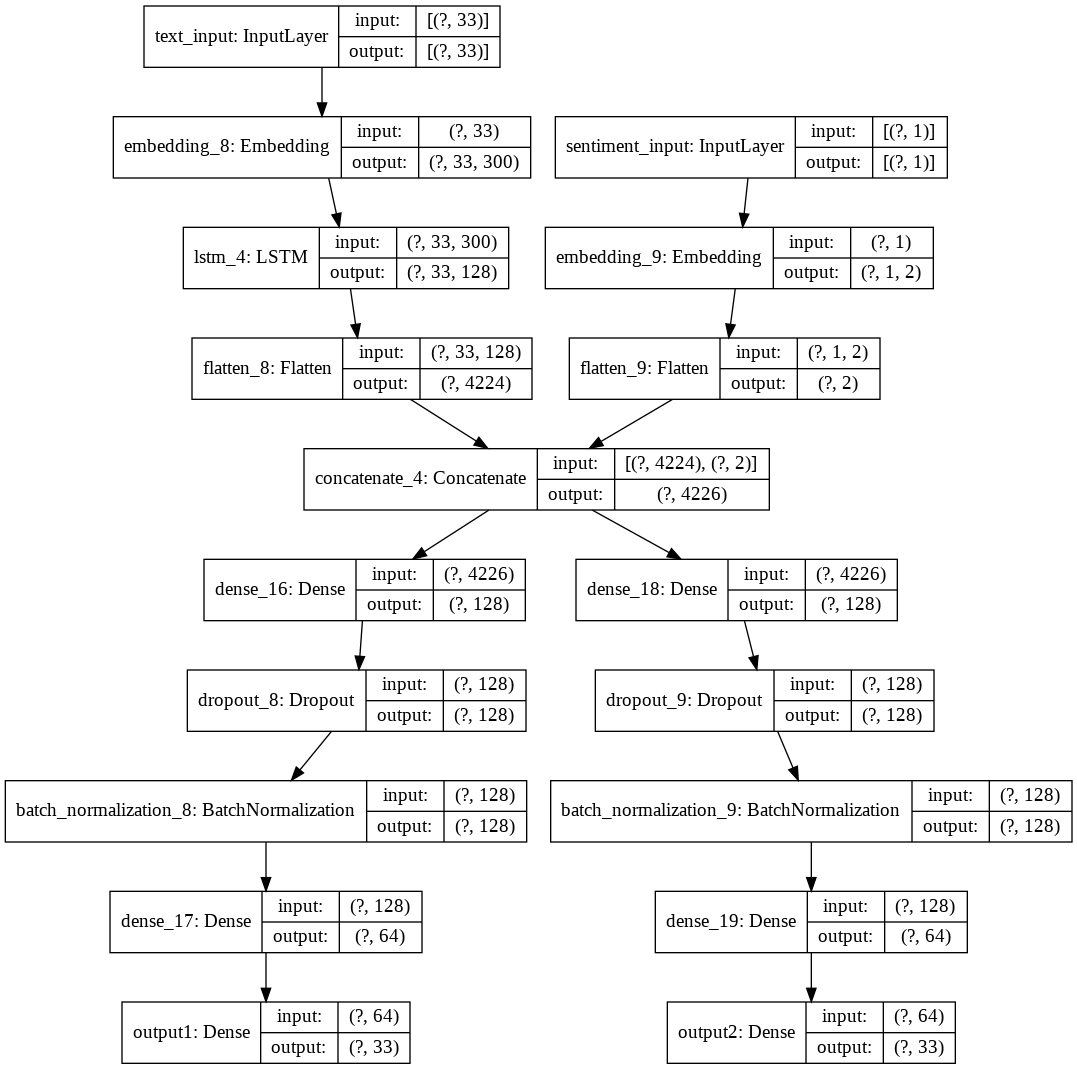

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
adam=optimizers.Adam(0.001)
model1.compile(loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'}, optimizer='adam')

In [ ]:
history1 = model1.fit([X_train_pad,train_sent],[y_train1,y_train2], epochs=15, batch_size=256,validation_data=([X_cv_pad,cv_sent],[y_cv1,y_cv2]), callbacks = [tensorboard_callback,lr_red])

In [ ]:
!rm -rf ./logs/ 

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir logs/fit

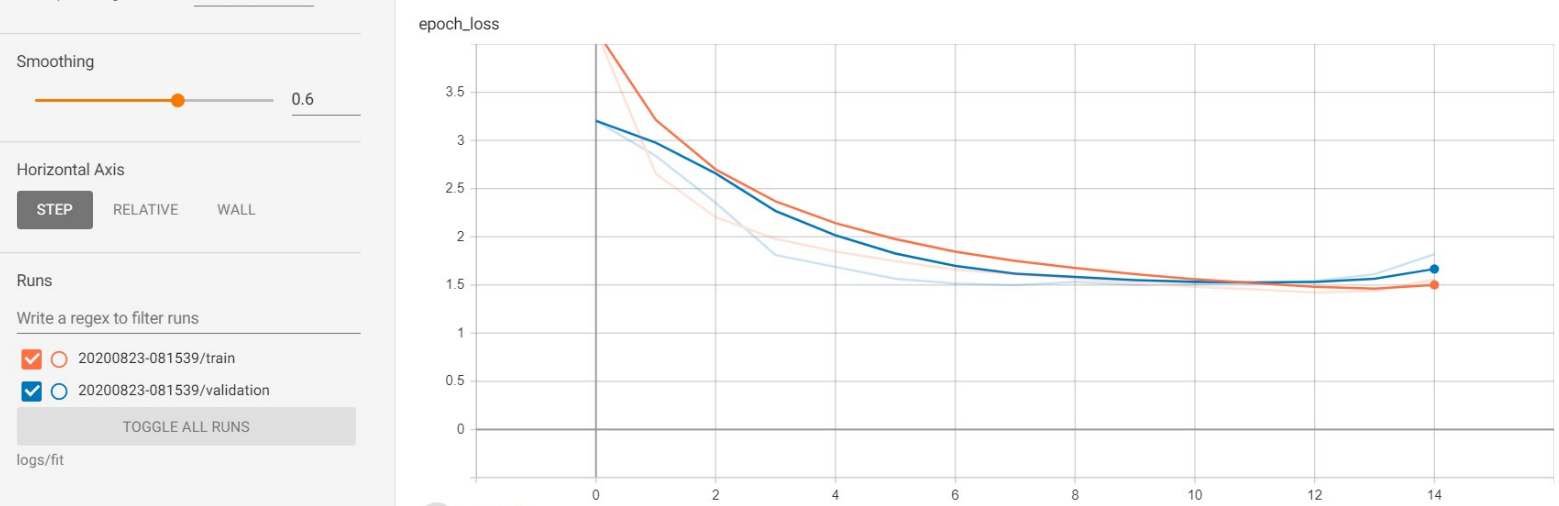

In [ ]:
from IPython.display import Image
Image('wordl.PNG')

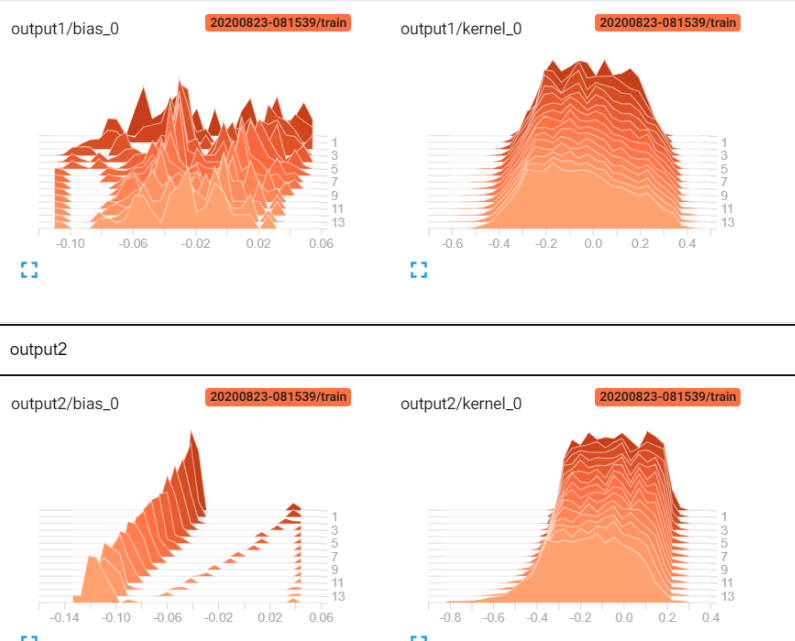

In [ ]:
Image('wordo1.PNG')

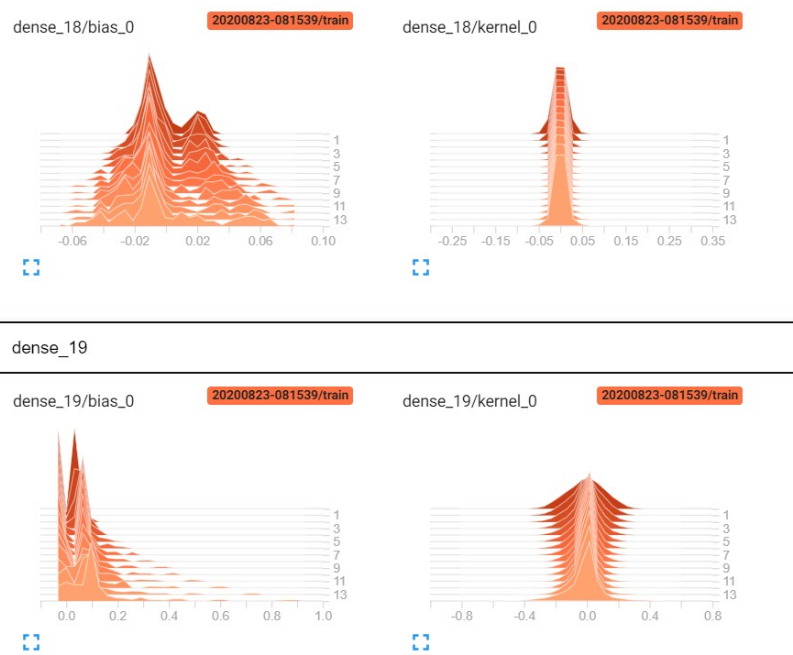

In [ ]:
Image('wordo2.PNG')

**Observations:** From loss plot,We can see that model is getting overfitted if we increase the epochs further,so we stop training here.From histogram plots, we can infer that the required layers are getting trained and weights are flowing throught the deep layers without any loss of information.so we can assume that our optimizer and the other hyper parameters taken are correct and this architecture on this data is not giving further improvements and we have to go for other models or try different architectures.

## Predictions on train and test data

In [ ]:
tr_pred1,tr_pred2 = model1.predict([X_train_pad,train_sent]) #predictions on train data
tr_pred1.shape,tr_pred2.shape

((24732, 33), (24732, 33))

In [ ]:
#getting the final predicted texts :
f_train=[]
for i in range(x_train.shape[0]):
  #print(i)
  #maxv= np.sort(tr_pred[i])[::-1][0:2] 
  #taking the  maximum values of each predictions
  s = np.argmax(tr_pred1[i]) #take these 2  values
  e = np.argmax(tr_pred2[i])
  if s>e: #marking start and end tokens based on the higher index values of above 2 values
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r='' #adding all the words to form a sentence
  #print(st,ed)
  for j in X_train_pad[i][st:ed+1]: #for each sentence,take the words between the start and end tokens 
    if j==0: #if the token predicted is zero(because x_train_pad has zero values), as tokenizer has now word with zero as index value, so skipping this value
      r=''
    else:
      #print(j)
      r= r+ tokenizer.index_word[j]+' ' #final predictions values of selected text
  f_train.append(r)
x_train['predictions'] = f_train #add these to dataframe

In [ ]:
cv_pred1,cv_pred2 = model1.predict([X_cv_pad,cv_sent]) #predictions on cv data
cv_pred1.shape,cv_pred2.shape

((2748, 33), (2748, 33))

In [ ]:
f_cv=[]
for i in range(x_cv.shape[0]):
  #maxv= np.sort(cv_pred[i])[::-1][0:2]
  s = np.argmax(cv_pred1[i])
  e = np.argmax(cv_pred2[i])
  if s>e:
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r=''
  for j in X_cv_pad[i][st:ed+1]:
    if j==0:
      r=''
    else:
      r= r+ tokenizer.index_word[j]+' '
  f_cv.append(r)
x_cv['predictions'] = f_cv

In [ ]:
x_train.head()

,textID,text,selected_text,sentiment,predictions
7763,6333438cd9,"Yeah, it`s good. Just startled me.",good.,positive,good just startled me
20238,d98f04843f,I know! I`m totally excited,y excited,positive,totally excited
25300,0adf28c5a1,feels very very sick hmph.,sick,negative,feels very very sick hmph
25755,1d88f35dd5,Whyyy am I still awake when I have to work at ...,This is not good,negative,good
24386,db2966df81,having a F**Kin` great day over there Graham ...,great day,positive,great day over there graham isn


In [ ]:
js=0
for i in range(x_train.shape[0]):
  js = js + jaccard(x_train.iloc[i,2],x_train.iloc[i,4])
print("final jaccard score for train data:",js/(x_train.shape[0]))

final jaccard score for train data: 0.46732768704501365


In [ ]:
js=0
for i in range(x_cv.shape[0]):
  js = js + jaccard(x_cv.iloc[i,2],x_cv.iloc[i,4])
print("final jaccard score for cv data:",js/(x_cv.shape[0]))

final jaccard score for cv data: 0.40922867938308977


In [ ]:
test_pred = model1.predict([X_test_pad,test_sent]) #final predictions on test data
test_pred.shape

(3534, 33)

In [ ]:
f_test=[]
for i in range(test.shape[0]):
  maxv= np.sort(test_pred[i])[::-1][0:2]
  s = list(test_pred[i]).index(maxv[0])
  e = list(test_pred[i]).index(maxv[1])
  if s>e:
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r=''
  for j in X_test_pad[i][st:ed+1]:
    if j==0:
      r=''
    else:
      r= r+ tokenizer.index_word[j]+' '
  f_test.append(r)
test['predictions'] = f_test

In [ ]:
test[['textID','predictions']].to_csv('submission2.csv',index=False) #final file for kaggle submission

**Observation:**with train score as 0.47 and cv as 0.41,we can see that performance is worse than the naive predictions.From the predictions,we can observe that even though the model is good at predcting the words that gives the respective sentiment meaning, still the score is not good.This may be due to the fact that noise in the data is contributing to the predictions.Because selected text is same as text including all the special characters,removing these during tokenizing has affected the model.Final score on test data after submission for lstm model is 0.48 which also indicates that removal of special characters is not a good idea.



#IMPROVEMENTS TO THE PRESENT MODEL:

I have tried woed level model without filtering during tokenization and preserving all the special characters,but the glove words doesn't contain vectors for the words like boring!,myself...,wait...be?..etc.. out of the total number of words in vocabulary of tokenizer,half of the words like the above doesn't has vectors and these will be zeros in embedding matrix.So we are loosing lot of data here,so it's not better idea to take the word level model even with filters.May be character level model is a good idea.

One more problem with this is the way the tokenizer is tokenizing the sentence,as tf tokenizer uses 'space' as separator to form tokens,the above problem raises beacause of this way of tokenization.May be we could try different way to tokenize the sentence using other libraries or write our own function to tokenize as per the given problem and data.Or else try the state of art tokenizers like bert for tokenizing and then take corresponding glove vectors for those tokens.But instead of taking glove vectors,it's better to take those bert's embeddings itself along with the model and fine tune them.It's all about experimentation and depending on the constraints we have,we may try all these in real world.

For this case study,let's try some methods as given below.




*   We can also try character level embeddings instead of word level LSTM model.

*   We can tune the latest state of the art models like Roberta instead of LSTM based model.



## LSTM model with character level

In [ ]:
from sklearn.model_selection import train_test_split #split train and cv data
x_train,x_cv,y_train,y_cv=train_test_split(train,train.sentiment,test_size=0.10,stratify=train.sentiment) #split wrt sentiment so that their distribution is equal in cv and train data
x_train.shape,x_cv.shape #train and cv data shapes

((24732, 4), (2749, 4))

In [ ]:
from sklearn import preprocessing
vectorizer = preprocessing.LabelEncoder() #encoding school state: train and test values
vectorizer.fit(x_train['sentiment'].values)
train_sent = vectorizer.transform(x_train['sentiment'].values)
cv_sent = vectorizer.transform(x_cv['sentiment'].values)
test_sent = vectorizer.transform(test['sentiment'].values)
print("After Label encoding")
print(train_sent.shape)
print(cv_sent.shape)
print(test_sent.shape)

After Label encoding
(24732,)
(2749,)
(3534,)


In [ ]:
MAX_SEQUENCE_LENGTH = max(x_train['text'].apply(len)) #maximum length of the sequence(maximum number of words for given sentence)
MAX_SEQUENCE_LENGTH

141

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenizing and padding
tokenizer = Tokenizer(char_level=True) #removing all the special symbols
tokenizer.fit_on_texts(x_train['text'].values)
X_train_sequences = tokenizer.texts_to_sequences(x_train['text'].values)
X_cv_sequences   =  tokenizer.texts_to_sequences(x_cv['text'].values)
X_test_sequences = tokenizer.texts_to_sequences(test['text'].values)

# return list with each element having word index numbers like : for 3 sentences in final,sequences : [1, 2, 2, 5, 6], [7, 3, 8, 4, 3, 9], [10, 11, 1, 4, 12]
word_index = tokenizer.word_index
print("unique characters in train data : {}".format(len(word_index)))
#padding to 141 characters
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #pre padding upto maximum number of words:33
X_cv_pad = pad_sequences(X_cv_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train tensor:',X_train_pad.shape)
print('Shape of cv tensor:',X_cv_pad.shape)
print('Shape of test tensor:',X_test_pad.shape)

unique characters in train data : 75
Shape of train tensor: (24732, 141)
Shape of cv tensor: (2749, 141)
Shape of test tensor: (3534, 141)


In [ ]:
print(word_index)

{' ': 1, 'e': 2, 't': 3, 'o': 4, 'a': 5, 'i': 6, 'n': 7, 's': 8, 'h': 9, 'r': 10, 'l': 11, 'd': 12, 'm': 13, 'y': 14, 'u': 15, 'g': 16, 'w': 17, '.': 18, 'c': 19, 'p': 20, 'f': 21, 'b': 22, 'k': 23, '!': 24, 'v': 25, '`': 26, ',': 27, '*': 28, 'j': 29, '/': 30, '?': 31, 'x': 32, '-': 33, ':': 34, 'z': 35, '2': 36, '0': 37, '1': 38, '_': 39, '3': 40, "'": 41, '4': 42, 'q': 43, ')': 44, '5': 45, '&': 46, '(': 47, '6': 48, '#': 49, '8': 50, '7': 51, '9': 52, ';': 53, '@': 54, '<': 55, '=': 56, 'ï': 57, '¿': 58, '½': 59, '~': 60, '$': 61, '+': 62, '>': 63, ']': 64, '%': 65, '^': 66, '[': 67, '|': 68, '\\': 69, '{': 70, '}': 71, 'â': 72, '\xa0': 73, '´': 74}


In [ ]:
#padding selected text:this will be used in getting start and end token values and there by extracting the target labels
X_train_sel = tokenizer.texts_to_sequences(x_train['selected_text'].values) 
X_train_sel_pad = pad_sequences(X_train_sel, maxlen=MAX_SEQUENCE_LENGTH)
X_cv_sel = tokenizer.texts_to_sequences(x_cv['selected_text'].values)
X_cv_sel_pad = pad_sequences(X_cv_sel, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train selected text tensor:',X_train_sel_pad.shape)
print('Shape of cv selected text tensor:',X_cv_sel_pad.shape)

Shape of train selected text tensor: (24732, 141)
Shape of cv selected text tensor: (2749, 141)


In [ ]:
#loading pre trained character glove vectors
embeddings_index = {}
f = open('datasets_39656_61504_glove.840B.300d-char.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 94 word vectors.


In [ ]:
#https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt
#https://www.kaggle.com/chenwgen/glove840b300dchar
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
 # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
#till now, we got embedded matrix with vectors

In [ ]:
embedding_matrix.shape,X_train_pad[0].shape

((76, 300), (141,))

In [ ]:
x_train[2:3]

,textID,text,selected_text,sentiment
11729,63fbc4be7a,home in carlsbad with the whole family for mot...,home in carlsbad with the whole family for mot...,neutral


In [ ]:
#comparing the text and selected texts and extracting the start and end tokens and get the target labels with start and end tokens as 1 and rest as 0
f1=[]
f2=[]
for i in range(x_train.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of start token as 1 and rest as zeros
  p=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of end token as 1 and rest as zeros
  start=0
  flag=0
  f=0
  for j in range(MAX_SEQUENCE_LENGTH):
    #print(X_train_sel_pad[i][j])
    if X_train_sel_pad[i][j]!=0  and flag==0 and X_train_sel_pad[i][j] in X_train_pad[i]: #once the start token is found,store the index and that element
      element = X_train_sel_pad[i][j]
      idx=j
      flag=1
    if flag==1: #after finding start token in text
      #print(start+f)
      start=list(X_train_pad[i][start+f:]).index(X_train_sel_pad[i][idx])+start+f #get that index 
      #start = start+f+start
      l_s = np.count_nonzero(X_train_sel_pad[i]) #length of the selected text
     # print(l_s)

     # print(i,start,l_s)
      if np.array_equal(X_train_sel_pad[i][idx:idx+l_s], X_train_pad[i][start:start+l_s]) is True: #if the starttoken+length --> if this part of text matches with selected text,then stop the iteration we found the selected text
          #print(X_train_pad[i][start:start+l_s])
          break
      else: #if we dont get the selected text in the first attempt of finding the start token, that means there are multiple tokens with the same number(i.e. same charcater may occur multiple times in a sentence right?)
      #so we found the wrong token, so continue searching for start token until starttoken+length --> this part of text matches with the selecetd text
          f=1
  end = start + l_s #start+length of selected text as end token
  #print(end)
  #print(start)
  t[start]=1
  p[end-1]=1
  #print(t)
  f1.append(t)
  f2.append(p)
y_train1 = np.array(f1)
y_train2 = np.array(f2)     
y_train1.shape,y_train2.shape

((24732, 141), (24732, 141))

In [ ]:
print(X_train_pad[581])
print(X_train_sel_pad[581])
print(f1[581])
print(f2[581])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  6 26 25  2  1 22  2  2  7  1 15 20  1 13  4  8  3  1  4 21  1 17  9  5
  3  1  7  4 10 13  5 11  1 20 20 11  1 19  4  7  8  6 12  2 10  1  3  9
  2  1  7  6 16  9  3 18  1  1  7  4  1 20 10  4 22 11  2 13  1 16  4  6
  7 16  1  3  4  1  8 11  2  2 20  1 22 15  3  1  7  6 16  9  3 13  5 10
  2  8  1 22  2  2  7  1 17  5 23  6  7 16  1 13  2  1 15 20 18]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  6 26 25  2  1 22  2  2  7  1 15 20  1 13  4  8  3  1  4 21  1 17  9  5
  3  1  7  4 10 13  5 11  1 20 20 11  1 19  4  7  8  6 12  2 10  1  3  9
  2  1  7  6 16  9  3 18  1  1  7  4  1 20 10  4 22 11  2 13  1 16  4  6
  7 16  1  3  4  1  8 11  2  2 20  1 22 15  3  1  7  6 16  9  3 13  5 10
  2  8  1 22  2  2  7  1 17  5 23  6  7 16  1 13  2  1 15 20 18]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
#comparing the text and selected texts and extracting the start and end tokens and get the target labels with start and end tokens as 1 and rest as 0
f3=[]
f4=[]
for i in range(x_cv.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH 
  p=[0]*MAX_SEQUENCE_LENGTH
  start=0
  flag=0
  f=0
  for j in range(MAX_SEQUENCE_LENGTH):
    #print(X_train_sel_pad[i][j])
    if X_cv_sel_pad[i][j]!=0  and flag==0 and X_cv_sel_pad[i][j] in X_cv_pad[i]: #once the start token is found,mark the values at the index 1
      element = X_cv_sel_pad[i][j]
      idx=j
      flag=1
    if flag==1:
      #print(start+f)
      start=list(X_cv_pad[i][start+f:]).index(X_cv_sel_pad[i][idx])+start+f
      #start = start+f+start
      l_s = np.count_nonzero(X_cv_sel_pad[i])
        #print(l_s)

      #print(i,start,l_s)
      if np.array_equal(X_cv_sel_pad[i][idx:idx+l_s], X_cv_pad[i][start:start+l_s]) is True:
          #print(X_train_pad[i][start:start+l_s])
          break
      else:
          f=1
  end = start + l_s
  #print(end)
  t[start]=1
  p[end-1]=1

    
  #print(t)
  f3.append(t)
  f4.append(p)
y_cv1 = np.array(f3)
y_cv2 = np.array(f4)   
y_cv1.shape,y_cv2.shape

((2749, 141), (2749, 141))

In [ ]:
#building model
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
emb_text = embedding_layer = Embedding(len(word_index)+1, #embedding layer with glove vectors as embeddings
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,mask_zero=True)(text_input)    #tried masking the input values with mask_zero= True,but there is no improvement in the predictions
lstm_out = LSTM(128,return_sequences=True,kernel_regularizer=regularizers.l2(0.001),)(emb_text) #lstm
flatten1=Flatten()(lstm_out)

senti_input=Input(shape=(1,), name='sentiment_input')
emb_st = Embedding(output_dim=2, input_dim=4)(senti_input) #embedding layer for categorical data
flatten2=Flatten()(emb_st)

x_con = concatenate([flatten1,flatten2])

x1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_con) #dense layers with drop outs and batch normalisation
x1=Dropout(0.5)(x1)
x1 =BatchNormalization()(x1)
x1 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x1)

output1 = Dense(MAX_SEQUENCE_LENGTH, activation='softmax', name='output1')(x1)


x2 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_con) #dense layers with drop outs and batch normalisation
x2=Dropout(0.5)(x2)
x2 =BatchNormalization()(x2)
x2 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x2)

output2 = Dense(MAX_SEQUENCE_LENGTH, activation='softmax', name='output2')(x2)

model2 = Model(inputs=[text_input,senti_input], outputs=[output1,output2])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

lr_red = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto',min_delta=0.000001)

In [ ]:
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 141)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 141, 300)     22800       text_input[0][0]                 
__________________________________________________________________________________________________
sentiment_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 141, 128)     219648      embedding[0][0]                  
_______________________________________________________________________________________

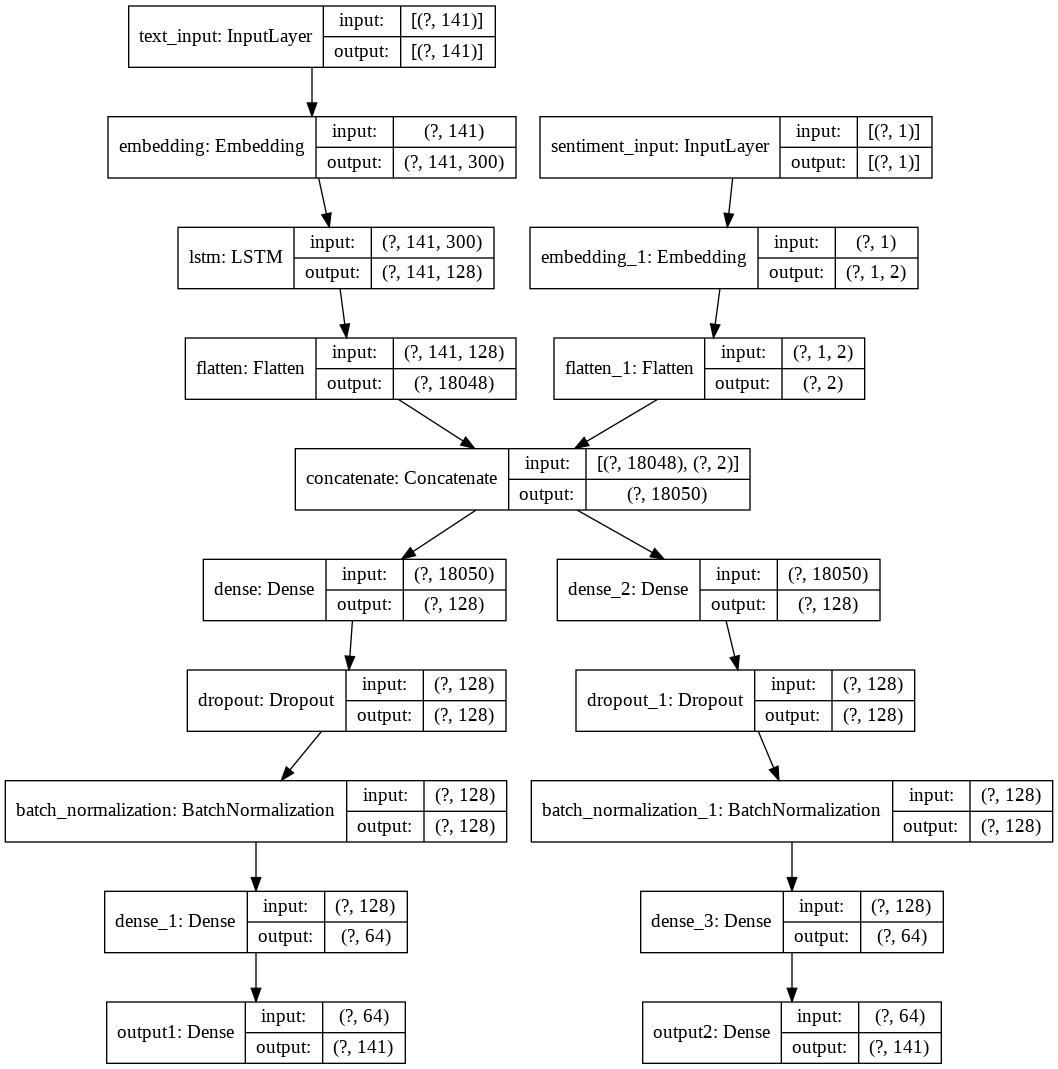

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
adam=optimizers.Adam(0.001)
#https://github.com/keras-team/keras/issues/10358 using different loss weights for each loss functions per batch(if you want batch wise loss weights changing,use this otherwise just use loss weights parameters as below) so that,only one loss function should not dominate the updation of weights(because loss with higher value will dominate the whole loss and updation of weights)
model2.compile(loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'}, optimizer='adam')#defining two losses for two outputs and weights are calculated for the total loss

In [ ]:
history2 = model2.fit([X_train_pad,train_sent],[y_train1,y_train2],epochs=15, batch_size=256,validation_data=([X_cv_pad,cv_sent],[y_cv1,y_cv2]), callbacks = [tensorboard_callback,lr_red] )

Epoch 1/15
 1/97 [..............................] - ETA: 0s - loss: 11.2813 - output1_loss: 5.1561 - output2_loss: 4.9815WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
97/97 [==============================] - 39s 401ms/step - loss: 8.3950 - output1_loss: 4.6003 - output2_loss: 3.0592 - val_loss: 7.3512 - val_output1_loss: 4.3385 - val_output2_loss: 2.5458
Epoch 2/15
97/97 [==============================] - 35s 366ms/step - loss: 6.9859 - output1_loss: 4.0838 - output2_loss: 2.5295 - val_loss: 7.2949 - val_output1_loss: 4.4489 - val_output2_loss: 2.5335
Epoch 3/15
97/97 [==============================] - 36s 368ms/step - loss: 6.4843 - output1_loss: 3.8041 - output2_loss: 2.3733 - val_loss: 7.0602 - val_output1_loss: 4.2743 - val_output2_loss: 2.4896
Epoch 4/1

In [ ]:
!rm -rf ./logs/ 

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir logs/fit

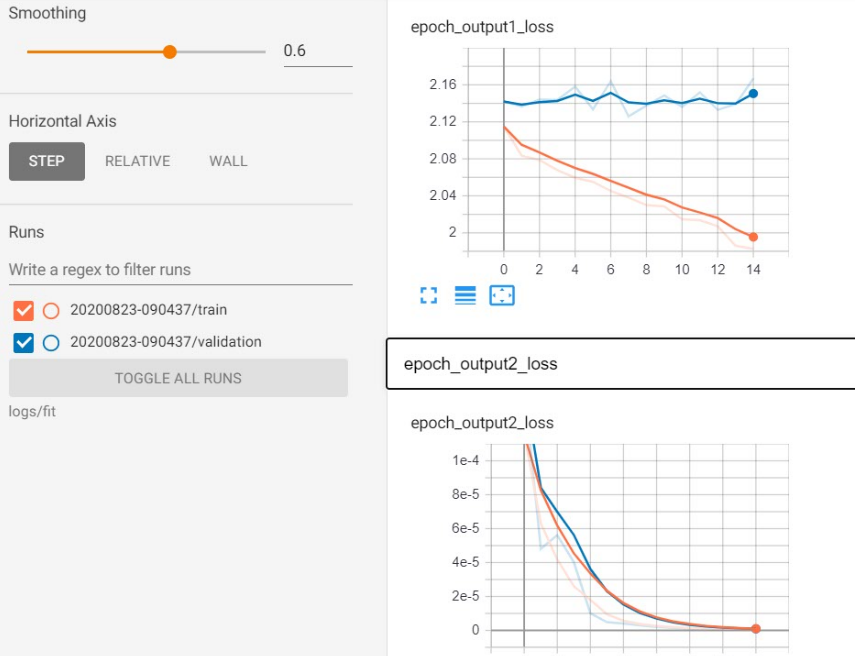

In [ ]:
Image('charl.PNG')

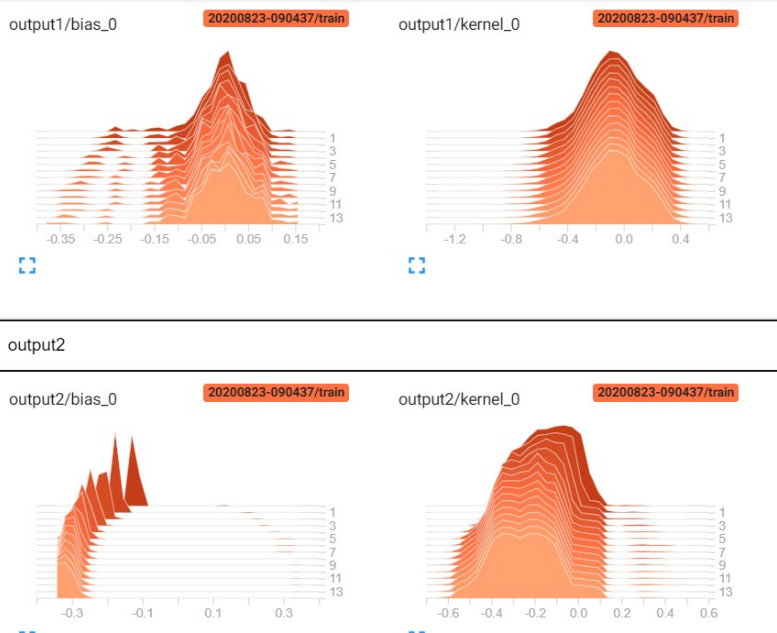

In [ ]:
Image('charo1.PNG')

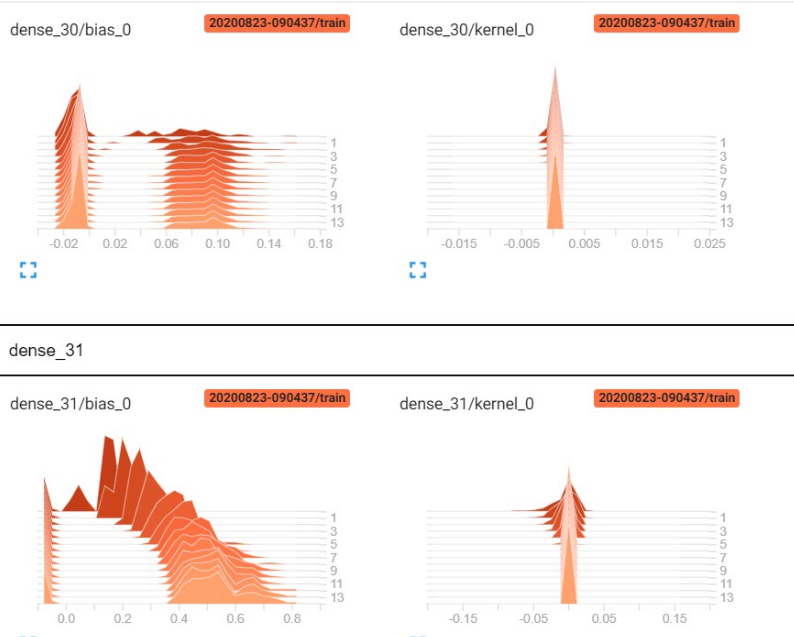

In [ ]:
Image('charo2.PNG')

**Observations:** Loss plots indicate that our model is going towards overfitting,so we will stop the training here.Histograms reveal that weights are updating with the epoch which is an indication that gradients are not strucking at one layer and are flowing through deeper layers well.We can assume that model is doing good job here and our choosen hyper parameter values are yielding good results and if we train further,there is chance of increasing errors in test data,as model is getting overfitted.We can try other architectures or use any state of the art models like BERT,if it improves the performance.

## Predictions on train and test data

In [ ]:
tr_pred1,tr_pred2 = model2.predict([X_train_pad,train_sent]) #predictions on train data
tr_pred1.shape,tr_pred2.shape

((24732, 141), (24732, 141))

In [ ]:
#getting the final predicted texts :
f_train=[]
for i in range(x_train.shape[0]):
  #print(i)
  #maxv= np.sort(tr_pred[i])[::-1][0:2] 
  #taking the first two maximum values of each predictions
  s = np.argmax(tr_pred1[i]) #take these 2  values
  e = np.argmax(tr_pred2[i])
  if s>e: #marking start and end tokens based on the higher index values of above 2 values
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r='' #adding all the words to form a sentence
  #print(st,ed)
  for j in X_train_pad[i][st:ed+1]: #for each sentence,take the words between the start and end tokens 
    if j==0: #if the token predicted is zero(because x_train_pad has zero values), as tokenizer has now word with zero as index value, so skipping this value
      r=''
    else:
      #print(j)
      r= r+ tokenizer.index_word[j]+'' #final predictions values of selected text
  f_train.append(r)
x_train['predictions'] = f_train #add these to dataframe

In [ ]:
cv_pred1,cv_pred2 = model2.predict([X_cv_pad,cv_sent]) #predictions on cv data
cv_pred1.shape,cv_pred2.shape

((2748, 141), (2748, 141))

In [ ]:
f_cv=[]
for i in range(x_cv.shape[0]):
  #maxv= np.sort(cv_pred[i])[::-1][0:2]
  s = np.argmax(cv_pred1[i])
  e = np.argmax(cv_pred2[i])
  if s>e:
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r=''
  for j in X_cv_pad[i][st:ed+1]:
    if j==0:
      r=''
    else:
      r= r+ tokenizer.index_word[j]+''
  f_cv.append(r)
x_cv['predictions'] = f_cv

In [ ]:
print(X_cv_pad[4])
print(X_cv_sel_pad[4])
print(f[4])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 34  1 29 15  8  3  1  3  9  2  1 12  6  7  7  2 10]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 34  1 29 15  8  3  1  3  9  2  1 12  6  7  7  2 10]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
x_train['st_len'] = x_train['selected_text'].str.split().apply(len)

In [ ]:
x_train[x_train['st_len']==1] #tried checking any patterns or common things in the texts where selecte text have only one word,but nothing useful

In [ ]:
x_train.head()

,textID,text,selected_text,sentiment,predictions,st_len
15337,73c39ec06b,Really wish I could have gone to this weekend,wish,positive,really wish i could have gone to this weekend,1
14763,5714d6ed93,Back from NYC... convinced on moving to the LE...,Back from NYC... convinced on moving to the LE...,neutral,back from nyc... convinced on moving to the le...,11
11729,63fbc4be7a,home in carlsbad with the whole family for mot...,home in carlsbad with the whole family for mot...,neutral,home in carlsbad with the whole family for mot...,10
19908,ea5cdc6030,Ohhh mannnn they just laid off 3 girls!!! T...,Ohhh mannnn they just laid off 3 girls!!! T...,neutral,ohhh mannnn they just laid off 3 girls!!! t...,14
26669,7b84ac125a,#myweakness too loving ...i always let negativ...,#myweakness too loving ...i always let negativ...,neutral,#myweakness too loving ...i always let negativ...,11


In [ ]:
x_cv.head()

,textID,text,selected_text,sentiment,predictions,naive
7445,cb64f6d942,is enjoying the night with her folks.,is enjoying the night with her folks.,positive,is enjoying the night with her folks.,is enjoying the night with her folks.
13191,86f53609e6,Traffic backed up inbound Lincoln tunnel,Traffic backed up inbound Lincoln tunnel,neutral,traffic backed up inbound lincoln tunnel,Traffic backed up inbound Lincoln tunnel
8458,e9505ad5d5,alright. i REALLY wish you guys could`ve done...,alright. i REALLY wish you guys could`ve done ...,neutral,alright. i really wish you guys could`ve done ...,alright. i REALLY wish you guys could`ve done...
21011,d55e51e012,my favourite song tonight is cheer it on by To...,favourite,positive,my favourite song tonight is cheer it on by to...,my favourite song tonight is cheer it on by To...
14480,5a45a070ed,Cathylo-fran! I`m glad i can vent out to you a...,Cathylo-fran! I`m glad i can vent out to you a...,positive,cathylo-fran! i`m glad i can vent out to you a...,Cathylo-fran! I`m glad i can vent out to you a...


In [ ]:
js=0
for i in range(x_train.shape[0]):
  try: #there is one null value in x_train data leave that
    js = js + jaccard(x_train.iloc[i,2],x_train.iloc[i,4])
  except:
    print(i)
print("final jaccard score for train data:",js/(x_train.shape[0]))

5257
final jaccard score for train data: 0.5886982040191668


In [ ]:
js=0   
for i in range(x_cv.shape[0]):
  js = js + jaccard(x_cv.iloc[i,2],x_cv.iloc[i,4])
print("final jaccard score for cv data:",js/(x_cv.shape[0]))

final jaccard score for cv data: 0.5640390027538728


In [ ]:
test_pred1,test_pred2 = model2.predict([X_test_pad,test_sent]) #final predictions on test data
test_pred1.shape,test_pred2.shape

((3534, 141), (3534, 141))

In [ ]:
f_test=[]
for i in range(test.shape[0]):
  s = np.argmax(test_pred1[i])
  e = np.argmax(test_pred2[i])
  if s>e:
    st = e
    ed = s
  elif e>s:
    st = s
    ed=  e
  else :
    st=ed=s
  r=''
  for j in X_test_pad[i][st:ed+1]:
    if j==0:
      r=''
    else:
      r= r+ tokenizer.index_word[j]+''
  f_test.append(r)
test['predictions'] = f_test

In [ ]:
test[['textID','predictions']].to_csv('submission5.csv',index=False) #final file for kaggle submission

**Observation:** We can see that model performance has improved greatly with the use of character level model.This indicates that more importance is given to characters rather than words.In other words,output selected text doesn't gaurantee the meaningful sentence,because it's just a sentence picked from given text with characters in it rather than having meaningful arrangement of the words.Also, special characters also playing important role here,so we have to take care of all these noise characters also.May be they are adding some meaning to the sentence,we dont know.But it seems that there is lot of meaningless and noise words in selected text without following any grammar syntax.So we cant expect the models to be 100% accurate on these type of problems and simple models like naive approach discussed at the start may work better than complex models in this case. 

We can observe that model is predicting selected text same as text which is naive,meaning that model is not able to find the correct relation or pattern in the output labels.May be the type of tokenization we are doing and the model architecture are not able to produce good result.we can try other tokenization systems like bert and the bert embeddings with this model architecture or better solution would be trying complex architectures like bert as they have millions of parameters and embeddings with contextual information, they may find some patterns in the output labels.

After submitting to kaggle,with the character level LSTM model,i got 0.59 as jaccard score,which is best result so far.



## Fine Tuning Roberta Model

Let's try some state of the art models and check if it improves the performance.

As our inputs and outputs both are texts and output is a part of input,we can model this as question answer system using state of the art models.These models are already pre trained with tons of data and we will be given these pre trained weights as initialisations for the model and we have to fine tune the model for our task.
We will use Roberta Model here and fine tune it for our data.

Question will be : sentiment of the given text

Paragraph/sentence  will be : given tweet

Answer  will be : selected text 

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 6.3MB/s 
     |████████████████████████████████| 1.1MB 18.4MB/s 
     |████████████████████████████████| 890kB 40.3MB/s 
     |████████████████████████████████| 3.0MB 32.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=707028b61b7077ca39032a06549eb4a7a93c2c0fc0627fa46d07cc7724f05ce8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForQuestionAnswering #importing necessary libraries

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') #initialsie pre trained tokenizer and get the pre trained  model with weights
robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base') #we will use roberta-base here

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The above warning means :
we are given just the weights of roberta model on which roberta is tuned on large dataset,but we have to fine tune them for our task.

similar issue : https://github.com/huggingface/transformers/issues/5421

As indicated qa_outputs which is a dense layer that is :
tf.keras.layers.Dense(config.num_labels, kernel_initializer=get_initializer(config.initializer_range), name="qa_outputs") (you can get these details from 
https://huggingface.co/transformers/_modules/transformers/modeling_tf_roberta.html#TFRobertaForQuestionAnswering
we have to fine tune this layer and any newly added layers for our question answer task.
So,as the output layers are initialised and not trained, if you give any question and sentences,it will give random answers.

### sample usage of roberta q&a system

In [ ]:
questi, tex =  "negative words?", "my boss is bullying me..." 
input_dict = tokenizer(questi, tex, return_tensors='tf')
start_scores, end_scores = model(input_dict)
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_scores, 1)[0] : tf.math.argmax(end_scores, 1)[0]+1])

In [ ]:
start_scores

<tf.Tensor: shape=(1, 17), dtype=float32, numpy=
array([[ 4.0427838e-03, -2.3874304e-01, -3.5950729e-01, -1.5995516e-01,
        -5.5252954e-02, -4.2292118e-02, -9.3214750e-02,  3.0273572e-04,
        -9.6969783e-02, -1.6879289e-01, -4.6670631e-02, -1.2501940e-02,
        -2.2292860e-01, -1.2944913e-01, -1.9245179e-01, -3.5165465e-01,
         3.0277669e-04]], dtype=float32)>

In [ ]:
end_scores

<tf.Tensor: shape=(1, 17), dtype=float32, numpy=
array([[0.06856712, 0.4769625 , 0.37525183, 0.4375453 , 0.38154167,
        0.39778012, 0.59180474, 0.06927525, 0.31693554, 0.31220078,
        0.3091114 , 0.3272599 , 0.29223222, 0.1854282 , 0.2396011 ,
        0.23264012, 0.0692753 ]], dtype=float32)>

In [ ]:
print(all_tokens)

['<s>', 'negative', 'Ġwords', '?', '</s>', '</s>', 'my', 'Ġboss', 'Ġis', 'Ġbullying', 'Ġme', '...', '</s>']


In [ ]:
input_dict['input_ids']

<tf.Tensor: shape=(1, 17), dtype=int32, numpy=
array([[    0, 12375,    21,  2488,   289, 13919,   116,     2,     2,
        24021,   289, 13919,    21,    10,  2579, 29771,     2]],
      dtype=int32)>

In [ ]:
input_dict['attention_mask']

<tf.Tensor: shape=(1, 17), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>

In [ ]:
answer

'<s> negative Ġwords ?'

We can see that answer is random and is not correct,so we have to fine tune this for better predictions.

for tf robert bert main layer : https://huggingface.co/transformers/_modules/transformers/modeling_tf_roberta.html#TFRobertaForQuestionAnswering (its same as tfbert layer with robert embeddings)
for tf bert layer : https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html (this layer returns sequence_output, pooled_output, (hidden_states), (attentions) as outputs)
so roberta also returns same outputs and we hae to take these outputs and have to fine tune them for our question answer task.
what we can do is: 1.take this question answering  model as it is along with dense layer and train the model with our data
or 2.take the first output of the main roberta pre trained model layer(which gives us the sequence output) and use our own dense layers or cnn layers and train the model with our questions and sentences.
https://huggingface.co/transformers/training.html

In [ ]:
robert_model.summary() #768*2=1536+2bias = 1538  dense layer with 2 neurons,as there are two lables

Model: "tf_roberta_for_question_answering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124645632 
_________________________________________________________________
qa_outputs (Dense)           multiple                  1538      
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
robert_model.num_labels

2

In [ ]:
#sample outputs of roberta model
#outputs = robert_model.roberta(input_dict['input_ids'][0:1],input_dict['attention_mask'][0:1])
##print(outputs[0].shape)
#logits = robert_model.qa_outputs(outputs[0])
#print(logits.shape)

(1, 105, 768)
(1, 105, 2)


In [ ]:
from sklearn.model_selection import train_test_split #split train and cv data
x_train,x_cv,y_train,y_cv=train_test_split(train,train.sentiment,test_size=0.10,stratify=train.sentiment) #split wrt sentiment so that their distribution is equal in cv and train data
x_train.shape,x_cv.shape #train and cv data shapes

((24732, 4), (2749, 4))

In [ ]:
train_idx = x_train.index.values
cv_idx = x_cv.index.values
train_idx.shape,cv_idx.shape

((24732,), (2749,))

In [ ]:
train_idx[0:10]

array([12955, 19994,  9230,   137, 10045, 15703, 11091,  4541, 18464,
        7684])

In [ ]:
text, question = list(train['text']),list(train['sentiment']) #get the tokenized values of given sentiment and and text values
input_dict = tokenizer(text, question, padding=True,return_tensors='tf') #you can take question first and then text, but during extracting output labels make sure you extract them accordingly

In [ ]:
max=0
for i in input_dict['input_ids']:
    if len(i)>max:
        max=len(i)
print("maximum length of text as per tokenisation of roberta is:",max)

#attention = np.array(input_dict['attention_mask']) shape:(27480,105)

maximum length of text as per tokenisation of roberta is: 105


Extracting Labels:
Lets extract two outputs : one for predicting start token and other for end token

starting token :1 and rest all :0

ending token : 1 and rest all :0

Extracting output labels for start and end tokens seperately

In [ ]:
#this extraction is inspired from this link :https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/comments#Training-Data
len_t = train.shape[0]
#len_t=1
MAX_LEN = 105
start_tokens = np.zeros((len_t,MAX_LEN),dtype='int32')
end_tokens = np.zeros((len_t,MAX_LEN),dtype='int32')
for k in range(0,train.shape[0]):
    text_t = " "+" ".join(train.loc[k,'text'].split())
    text_s = " ".join(train.loc[k,'selected_text'].split())
    #print(text_t)
    #print(text_s)
    idx = text_t.find(text_s)
    #print(idx)
    chars = np.zeros((len(text_t)))
    chars[idx:idx+len(text_s)]=1
    
    if text_t[idx-1]==' ':
        chars[idx-1] = 1 
    #print(chars)
    #print("length of chars:",len(chars))
    offsets = []; idx=0
    enc = tokenizer.encode(text_t)
    for t in enc:
            w = tokenizer.decode([t])
            #print(w,t)
            if t==0 or t==2:
                offsets.append((idx,idx+0))
                idx +=0
            else:
                offsets.append((idx,idx+len(w)))
                idx += len(w)
    #print(offsets)
    toks = []
    s= np.argmax(chars)
    e= len(chars)-1-np.argmax(chars[::-1])
    #print("common:",s,e)
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(i) 
    #print(toks)
    if len(toks)>0:
            start_tokens[k,toks[0]] = 1
            end_tokens[k,toks[-1]+1] = 1
    #print(tokenizer.decode(enc[toks[0]:toks[-1]+1]))
    
start_tokens.shape,end_tokens.shape

((27481, 105), (27481, 105))

Model Architecture

In [ ]:
def build_model():
    x_ids = Input((105,),dtype=tf.int32)
    x_att = Input((105,),dtype=tf.int32)
  #robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')
    outputs = robert_model(x_ids,attention_mask=x_att)  #dense layer with 2 neurons and activation=none
    #these outputs are logits before softmax,so we have to do softmax
   
    o1 = tf.keras.layers.Activation('softmax')(outputs[0])
    o2 = tf.keras.layers.Activation('softmax')(outputs[1])
    model = Model(inputs=[x_ids,x_att], outputs=[o1,o2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #labels = [start,end]
    #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #we can do this or take softmax layers seperately as above o1 and o2
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [ ]:
final = build_model()
final.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 105)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 105)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_question_answeri ((None, 105), (None, 124647170   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 105)          0           tf_roberta_for_questio

In [ ]:
#K.clear_session()
x_train1,x_train2=np.array(input_dict['input_ids'])[train_idx,],np.array(input_dict['attention_mask'])[train_idx,]
x_cv1,x_cv2  =    np.array(input_dict['input_ids'])[cv_idx,],np.array(input_dict['attention_mask'])[cv_idx,]
start,end = start_tokens[train_idx,],end_tokens[train_idx,]
y_s,y_e   = start_tokens[cv_idx,],end_tokens[cv_idx,]
#callbacks for our required tasks
#you cant save a subclassed model in keras, raising NotImplementedError: so save only weights
#https://github.com/keras-team/keras/issues/12922
#https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
saving  = ModelCheckpoint("/content/best_model_{loss:.4f}.h5", monitor='loss', verbose=1, save_best_only=True,save_weights_only=True, mode='auto', save_freq='epoch')
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),histogram_freq=1, write_graph=True,write_grads=True)
lr_red = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto',min_delta=0.000000001)

final_model = build_model()

history1 = final_model.fit([x_train1,x_train2],[start,end],epochs=10,batch_size=32,validation_data=([x_cv1,x_cv2],[y_s,y_e]),callbacks=[tensorboard_callback,saving,lr_red])

Epoch 1/10
  1/773 [..............................] - ETA: 0s - loss: 9.2907 - activation_14_loss: 4.6783 - activation_15_loss: 4.6124WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
773/773 [==============================] - ETA: 0s - loss: 2.7822 - activation_14_loss: 1.1788 - activation_15_loss: 1.6034
Epoch 00001: loss improved from inf to 2.78221, saving model to /content/best_model_2.7822.h5
773/773 [==============================] - 1288s 2s/step - loss: 2.7822 - activation_14_loss: 1.1788 - activation_15_loss: 1.6034 - val_loss: 2.0306 - val_activation_14_loss: 0.8928 - val_activation_15_loss: 1.1378
Epoch 2/10
773/773 [==============================] - ETA: 0s - loss: 1.9251 - activation_14_loss: 0.8856 - activation_15_loss: 1.0395
Epoch 00002: loss im

In [ ]:
#!rm -rf ./logs/ 
%load_ext tensorboard
%tensorboard --logdir logs/fit/

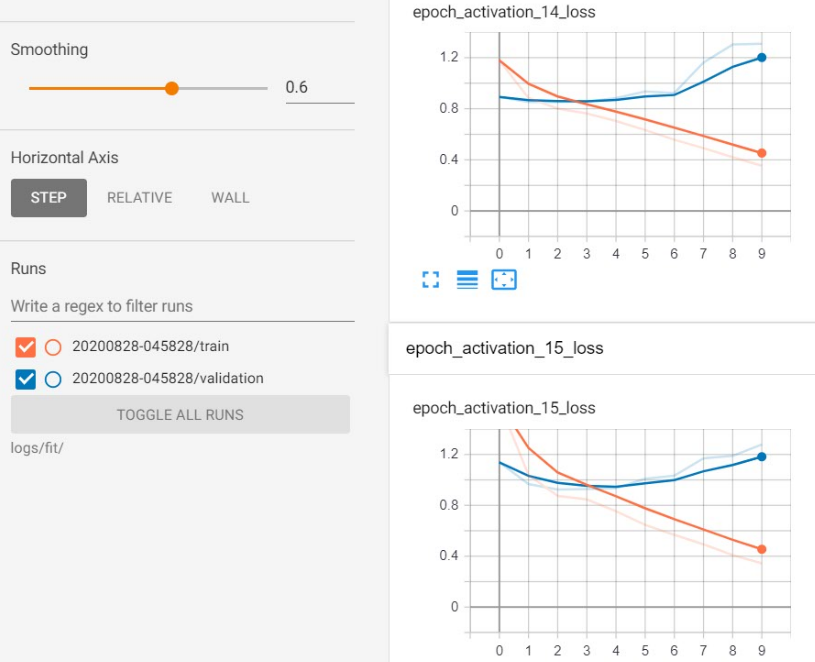

In [ ]:
Image('robl.PNG')

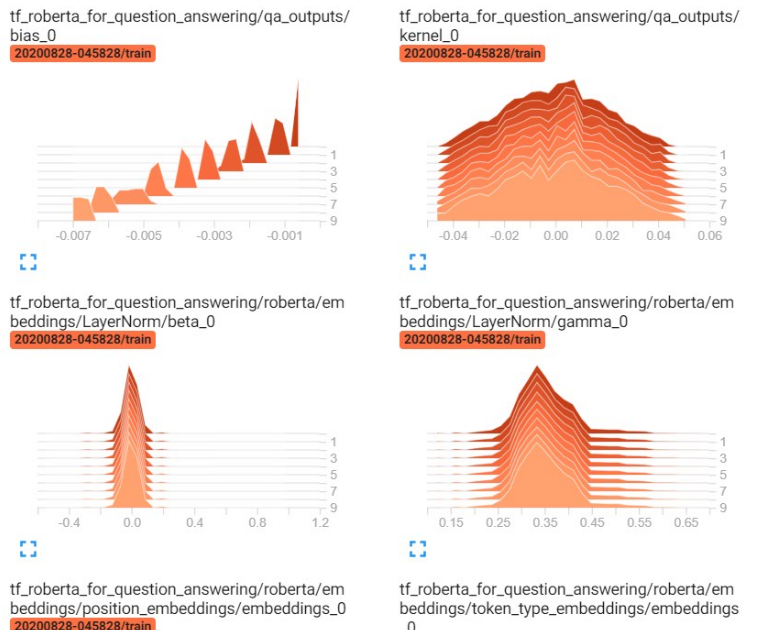

In [ ]:
Image('robo1.PNG')

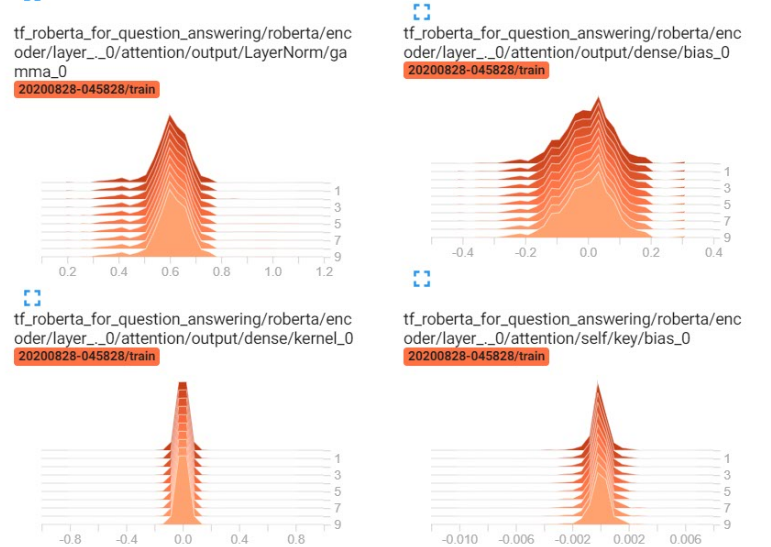

In [ ]:
Image('robo2.PNG')

**Observations:** Loss plots indicate that after 3 epochs,model is getting overfitted and if we train further we may reach best jaccard score on train data,but the model performs worst on unseen test data,which is clear from increase in cv loss.Also,histograms indicate that our layer weights are getting updated,but the change is minimal,because we used less learning rate.This is obvious that,we are fine tuning the pre trained model,we have to use less learning rates so that original weights won't get distracted much.The same can be inferred from histogram plots.

## Predictions on train and test data

### Train data

In [ ]:
p_model = build_model()
p_model.load_weights('/content/best_model_1.6744.h5') #pick the best model which is neither underfitting nor overfitting

In [ ]:
start_pred,end_pred = p_model.predict([x_train1,x_train2]) #predict on train data
start_pred.shape,end_pred.shape

((24732, 105), (24732, 105))

In [ ]:
predict=[] #final outputs of train data and decoding to get predicted selected text values
actual=[]
for i,j in enumerate(train_idx):
    #print(j)
    s=np.argmax(start_pred[i]) #get index of maximum value
    e=np.argmax(end_pred[i])
    #print(s,e)
    if s<=e: #if start token index is less than end token index
        op = tokenizer.decode(input_dict['input_ids'][j:j+1].numpy()[0][s:e+1]) #take that output
        #print(op)
        #op = op.replace('</s>','')
        #op = op.replace('<pad>','')
        
        predict.append(op)
        #print("output",op,'\n')
        actual.append(train[j:j+1]['selected_text'].values[0])
    else: #if start token is greater than end token

    #this extraction of output where indexes of  end token>start token may yield different results based on the way we select the indexes,so we have to experiment with it and select
    #the best condition which yields the best score
    #from naive model predictions,it's clear that taking text as it is may yield good predictions, so,  take the whole text as it as selected text for this condition
        #print("as:",train[j:j+1]['text'].values[0])
        #print(train[j:j+1]['selected_text'].values[0])
        op = train[j:j+1]['text'].values[0]
        actual.append(train[j:j+1]['selected_text'].values[0])
        #op = tokenizer.decode(text['input_ids'][j:j+1].numpy()[0][e:s+1])
        #op = op.replace('</s>','')
        #op = op.replace('<s>','')
        #op = op.replace('<pad>','')
        #print("output",op,'\n')
        #print(train[j:j+1]['selected_text'].values[0])
        predict.append(op)

In [ ]:
js=0   
for i in range(train_idx.shape[0]):
            js = js + jaccard(predict[i],actual[i])
print("final jaccard score for train data:",js/(train_idx.shape[0]))

final jaccard score for train data: 0.6909012657808279


### CV data

In [ ]:
start_predv,end_predv = p_model.predict([x_cv1,x_cv2]) #predictions on cv data
start_predv.shape,end_predv.shape

((2749, 105), (2749, 105))

In [ ]:
predictv=[]
actualv=[]
for i,j in enumerate(cv_idx):
    #print(j)
    s=np.argmax(start_predv[i])
    e=np.argmax(end_predv[i])
    #print(s,e)
    if s<=e:
        op = tokenizer.decode(input_dict['input_ids'][j:j+1].numpy()[0][s:e+1])
        #print(op)
        #op = op.replace('</s>','')
        #op = op.replace('<pad>','')
        
        predictv.append(op)
        #print("output",op,'\n')
        actualv.append(train[j:j+1]['selected_text'].values[0])
    else:
        #print("as:",train[j:j+1]['text'].values[0])
        #print(train[j:j+1]['selected_text'].values[0])
        op = train[j:j+1]['text'].values[0]
        actualv.append(train[j:j+1]['selected_text'].values[0])
        #op = tokenizer.decode(text['input_ids'][j:j+1].numpy()[0][e:s+1])
        #op = op.replace('</s>','')
        #op = op.replace('<s>','')
        #op = op.replace('<pad>','')
        #print("output",op,'\n')
        #print(train[j:j+1]['selected_text'].values[0])
        predictv.append(op)

In [ ]:
js=0   
for i,j in enumerate(cv_idx):
    if j!=314: #index 314 has empty values in train data,so predicting jaccard score results in zero division error,so just leave out that row
            js = js + jaccard(predictv[i],actualv[i])
print("final jaccard score for cv data:",js/(cv_idx.shape[0]))

final jaccard score for cv data: 0.6602536409420239


### Test data

Tokenizing Test data

If we use tokenizer() to get the tokens,maximum length of sentences will be different,which will raise warning,but we can ignore it.But let's tokenize manually,so that we can know what's happening inside tokenizer of roberta.

In [ ]:
tokenizer.encode('neutral'),tokenizer.encode('positive'),tokenizer.encode('negative') 

([0, 12516, 2], [0, 22173, 2], [0, 33407, 2])

In [ ]:
sentiment_id = {'positive': 22173, 'negative': 33407, 'neutral': 12516}

In [ ]:
len_t = test.shape[0] #manual tokenization
input_ids_t = np.ones((len_t,MAX_LEN),dtype='int32') #maximum length of train texts which is 105
attention_mask_t = np.zeros((len_t,MAX_LEN),dtype='int32')
for k in range(test.shape[0]):
    # INPUT_IDS
    text_t = test.loc[k,'text']
    enc = tokenizer.encode(text_t)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc)+3] =  enc + [2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc)+3] = 1

In [ ]:
#x_test1,x_test2=np.array(input_dict_test['input_ids'])[idxTEST,],np.array(input_dict_test['attention_mask'])[idxTEST,]
start_predt,end_predt = p_model.predict([input_ids_t,attention_mask_t])
start_predt.shape,end_predt.shape #maximum length  is same as train

((3534, 105), (3534, 105))

In [ ]:
predictt=[]
#actualt=[]
for i,j in enumerate(range(0,input_ids_t.shape[0])):
    #print(j)
    s=np.argmax(start_predt[i])
    e=np.argmax(end_predt[i])
    #print(s,e)
    if s<=e:
        op = tokenizer.decode(input_ids_t[i:i+1][0][s:e+1])
        #print(op)
        #op = op.replace('</s>','')
        #op = op.replace('<pad>','')
        
        predictt.append(op)
        #print("output",op,'\n')
        #actual.append(test[j:j+1]['selected_text'].values[0])
    else:
        #print("as:",train[j:j+1]['text'].values[0])
        #print(train[j:j+1]['selected_text'].values[0])
        op =test[i:i+1]['text'].values[0]
        #actual.append(train[j:j+1]['selected_text'].values[0])
        #op = tokenizer.decode(text['input_ids'][j:j+1].numpy()[0][e:s+1])
        #op = op.replace('</s>','')
        #op = op.replace('<s>','')
        #op = op.replace('<pad>','')
        #print("output",op,'\n')
        #print(train[j:j+1]['selected_text'].values[0])
        predictt.append(op)

In [ ]:
test['predictions'] = predictt #final test predictions
#test.head()

In [ ]:
test[['textID','predictions']].to_csv('final.csv',index=False) #saving the test predictions to submit to kaggle

**Observations:** With 0.69 jaccard score on train data and 0.67 score on cv data, this fine tuned model is yielding the best results so far.Test predictions from this model are also submitted to kaggle and got 0.70 jaccard score,which is the best so far models we tried.It is known that transfer leraning will give good results in nlp tasks and with this case study we once again verified and confirmed the same.But we have to be careful abour learning rate and other sensitive parameters,so that weights wont get distracted much from original weights.But the only drawback of the model is it is taking long time for training,which is quite clear that as we are fine tuning the whole model and there are millions of weights that are to be updated per each step.

##MANY-MANY ARCHITECTURE WITH LSTM

One of the draw backs of modelling this problem as prediction of start and end tokens is that, these models only work for the length that we have defined during training,because of the usage of fixed neurons(equal to number of labels)dense layer at the output.So if we get any sentence whose length is greater than the max length in training data,we can't predict that.

So, let's model this as many to many type model,where we predict whether each word is present in the selected text or not.So, for each word in input text,we will train the model to predict whether that word will be present in selected text or not.

As we have already seen that character level model is giving better model than word level,let's take the character level model here.

In [ ]:
from sklearn.model_selection import train_test_split #split train and cv data
x_train,x_cv,y_train,y_cv=train_test_split(train,train.sentiment,test_size=0.10,stratify=train.sentiment) #split wrt sentiment so that their distribution is equal in cv and train data
x_train.shape,x_cv.shape #train and cv data shapes

((24732, 4), (2749, 4))

In [ ]:
x_train['text'] =  x_train['sentiment'] + ' ' + x_train['text']
x_cv['text'] =  x_cv['sentiment'] + ' ' + x_cv['text']#adding sentiment of the word to text column,so that we can embedd the sentiment information into the model
#as it is a many-many lstm model,we get an word representation only after getting the previous words info from lstm hidden states:
#ex: i am a good boy: if i want to classify the word good whether it will be present in the output or not, i have to get the word representation(which is contextual representation as we are taking lstm,it will preserve the sequential info)
#this word representation tell us in what sense it is used in this sentence based on the words seen so far(remember we are using one directional i.e. forward lstm only)
#so i will get the good word representation and i can classify it.If i add the sentiment word at the end,then the word representations before this sentiment word wont have the info of sentiment word,as i am taking forward lstm.
#so we have to add the word at the beginning itself to preserve the sentiment info.

In [ ]:
MAX_SEQUENCE_LENGTH = max(x_train['text'].apply(len)) #maximum length of the sequence(maximum number of characters for given sentence)
MAX_SEQUENCE_LENGTH

150

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenizing and padding
tokenizer = Tokenizer(char_level=True) #removing all the special symbols
tokenizer.fit_on_texts(x_train['text'].values)
X_train_sequences = tokenizer.texts_to_sequences(x_train['text'].values)
X_cv_sequences   =  tokenizer.texts_to_sequences(x_cv['text'].values)
X_test_sequences = tokenizer.texts_to_sequences(test['text'].values)

# return list with each element having word index numbers like : for 3 sentences in final,sequences : [1, 2, 2, 5, 6], [7, 3, 8, 4, 3, 9], [10, 11, 1, 4, 12]
word_index = tokenizer.word_index
print("unique characters in train data : {}".format(len(word_index)))
#padding to 141 characters
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #pre padding upto maximum number of characters 141
X_cv_pad = pad_sequences(X_cv_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train tensor:',X_train_pad.shape)
print('Shape of cv tensor:',X_cv_pad.shape)
print('Shape of test tensor:',X_test_pad.shape)

unique characters in train data : 75
Shape of train tensor: (24732, 150)
Shape of cv tensor: (2749, 150)
Shape of test tensor: (3534, 150)


In [ ]:
print(word_index)

{' ': 1, 'e': 2, 't': 3, 'o': 4, 'a': 5, 'i': 6, 'n': 7, 's': 8, 'r': 9, 'h': 10, 'l': 11, 'u': 12, 'd': 13, 'g': 14, 'm': 15, 'y': 16, 'w': 17, '.': 18, 'p': 19, 'c': 20, 'v': 21, 'f': 22, 'b': 23, 'k': 24, '!': 25, '`': 26, ',': 27, '*': 28, 'j': 29, '/': 30, '?': 31, 'x': 32, '-': 33, ':': 34, 'z': 35, '2': 36, '0': 37, '1': 38, '_': 39, '3': 40, "'": 41, '4': 42, 'q': 43, ')': 44, '5': 45, '&': 46, '(': 47, '6': 48, '#': 49, '8': 50, '7': 51, '9': 52, ';': 53, '<': 54, '@': 55, 'ï': 56, '¿': 57, '½': 58, '=': 59, '~': 60, '$': 61, '+': 62, '>': 63, ']': 64, '%': 65, '^': 66, '[': 67, '|': 68, '\\': 69, '}': 70, '{': 71, 'â': 72, '\xa0': 73, '´': 74, '\t': 75}


In [ ]:
#padding selected text:this will be used in getting start and end token values and there by extracting the target labels
X_train_sel = tokenizer.texts_to_sequences(x_train['selected_text'].values) 
X_train_sel_pad = pad_sequences(X_train_sel, maxlen=MAX_SEQUENCE_LENGTH)
X_cv_sel = tokenizer.texts_to_sequences(x_cv['selected_text'].values)
X_cv_sel_pad = pad_sequences(X_cv_sel, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train selected text tensor:',X_train_sel_pad.shape)
print('Shape of cv selected text tensor:',X_cv_sel_pad.shape)

Shape of train selected text tensor: (24732, 150)
Shape of cv selected text tensor: (2749, 150)


In [ ]:
#loading pre trained character glove vectors
embeddings_index = {}
f = open('datasets_39656_61504_glove.840B.300d-char.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s character vectors.' % len(embeddings_index))

Found 94 character vectors.


In [ ]:
#https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt
#https://www.kaggle.com/chenwgen/glove840b300dchar
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
 # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
#till now, we got embedded matrix with vectors

In [ ]:
embedding_matrix.shape,X_train_pad[0].shape

((76, 300), (150,))

In [ ]:
#comparing the text and selected texts and extracting the start and end tokens and get the target labels with start and end tokens as 1 and rest as 0
f1=[]
for i in range(x_train.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of start and end tokens as 1 and rest as 0
  start=0
  flag=0
  f=0
  for j in range(MAX_SEQUENCE_LENGTH):
    #print(X_train_sel_pad[i][j])
    if X_train_sel_pad[i][j]!=0  and flag==0 and X_train_sel_pad[i][j] in X_train_pad[i]: #once the start token is found,store the index and that element
      element = X_train_sel_pad[i][j]
      idx=j
      flag=1
    if flag==1: #after finding start token in text
      #print(start+f)
      start=list(X_train_pad[i][start+f:]).index(X_train_sel_pad[i][idx])+start+f #get that index 
      #start = start+f+start
      l_s = np.count_nonzero(X_train_sel_pad[i]) #length of the selected text
        #print(l_s)

      #print(i,start,l_s)
      if np.array_equal(X_train_sel_pad[i][idx:idx+l_s], X_train_pad[i][start:start+l_s]) is True: #if the starttoken+length --> if this part of text matches with selected text,then stop the iteration we found the selected text
          #print(X_train_pad[i][start:start+l_s])
          break
      else: #if we dont get the selected text in the first attempt of finding the start token, that means there are multiple tokens with the same number(i.e. same charcater may occur multiple times in a sentence right?)
      #so we found the wrong token, so continue searching for start token until starttoken+length --> this part of text matches with the selecetd text
          f=1
  end = start + l_s #start+length of selected text as end token
  #print(end)
  for k in range(start,end): #mark all the characters between start and end token,we are marking the selected text character as  in text data
    t[k]=1
    
  #print(t)
  f1.append(t)
y_train = np.array(f1)
      
y_train.shape

(24732, 150)

In [ ]:
x_train[251:252]

,textID,text,selected_text,sentiment
16968,28d8ef8118,negative NO FREE WIFI!?!? My vacay is ruined!!!!,ruined!!,negative


In [ ]:
print(X_train_pad[251]) #sample encoding
print(X_train_sel_pad[251])
print(y_train[251])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  7  2 14  5  3  6 21  2  1  7  4  1 22  9  2  2  1 17
  6 22  6 25 31 25 31  1 15 16  1 21  5 20  5 16  1  6  8  1  9 12  6  7
  2 13 25 25 25 25]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9 12
  6  7  2 13 25 25]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [ ]:
#comparing the text and selected texts and extracting the start and end tokens and get the target labels with start and end tokens as 1 and rest as 0
f3=[]
for i in range(x_cv.shape[0]):
  t=[0]*MAX_SEQUENCE_LENGTH #list for storing indices of start and end tokens as 1 and rest as 0
  start=0
  flag=0
  f=0
  for j in range(MAX_SEQUENCE_LENGTH):
    #print(X_train_sel_pad[i][j])
    if X_cv_sel_pad[i][j]!=0  and flag==0 and X_cv_sel_pad[i][j] in X_cv_pad[i]: #once the start token is found,mark the values at the index 1
      element = X_cv_sel_pad[i][j]
      idx=j
      flag=1
    if flag==1:
      #print(start+f)
      start=list(X_cv_pad[i][start+f:]).index(X_cv_sel_pad[i][idx])+start+f
      #start = start+f+start
      l_s = np.count_nonzero(X_cv_sel_pad[i])
        #print(l_s)

      #print(i,start,l_s)
      if np.array_equal(X_cv_sel_pad[i][idx:idx+l_s], X_cv_pad[i][start:start+l_s]) is True:
          #print(X_train_pad[i][start:start+l_s])
          break
      else:
          f=1
  end = start + l_s
  #print(end)
  for k in range(start,end):
    t[k]=1
    
  #print(t)
  f3.append(t)
y_cv = np.array(f3)
      
y_cv.shape

(2749, 150)

Masking

As we are taking padded sequence,we have to mask them so that they won't be included in loss calculation.But our output is a part of sentence,not all the sentence,so we can't use the output labels as masked values.we have to form seperate mask vectors and at the time of  loss calcuation,we have to use them to avoid adding padded values to loss.

we can do it by using eager execution of the model and using gradient tape,but we will be loosing the ease of using callbacks like tensorboard,lr reducing...,we have to write all these call backs separately and then use them.so,instead of following this method,we can introduce a small hack here:
https://stackoverflow.com/questions/57704771/inputs-to-eager-execution-function-cannot-be-keras-symbolic-tensors

https://stackoverflow.com/questions/46464549/keras-custom-loss-function-accessing-current-input-pattern

The errors raised during different approaches and the above mentioned links lead to this hack:

we have to somehow embed the masked vectors information in output vector so that duting custom loss function,we can invert back the mask vector from output vector an use that while calculating loss.

so i have added masked vector to output label vector and at the time of calculating loss, i have extracted masked vector from output vector.The code is given below and detailed explanation is given in the cell below model plot.



In [ ]:
mask=[] #preparing masked vector
for i in X_train_pad:
  m=[0]*MAX_SEQUENCE_LENGTH
  for j,k in enumerate(i):
    #print(j)
    if k!=0:
      m[j]=1
  mask.append(m)
mask_train = np.array(mask)
mask_train.shape

(24732, 150)

In [ ]:
x_train[0:1]

,textID,text,selected_text,sentiment
11913,2dd635e929,hahaha.. sadly this one`s supposed to be done...,hahaha.. sadly this one`s supposed to be done ...,neutral


In [ ]:
f_train = mask_train + y_train #add masked and output vector and this will be our final output vector that will be used at the time of training
f_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
mask=[] #masked vector for cv data
for i in X_cv_pad:
  m=[0]*MAX_SEQUENCE_LENGTH
  for j,k in enumerate(i):
    #print(j)
    if k!=0:
      m[j]=1
  mask.append(m)
mask_cv = np.array(mask)
mask_cv.shape

(2749, 150)

In [ ]:
f_cv = mask_cv + y_cv #final cv data
f_cv[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
h=f_cv[0] 
h[h<2]=0
h[h>0]=1
h

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#building model
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input') #input layer
emb_text = embedding_layer = Embedding(len(word_index)+1, #embedding layer with glove vectors as embeddings
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,mask_zero=True)(text_input)    #masking the input padded values with mask_zero= True, so that they wont be involved in lstm calculations
lstm_out = LSTM(128,return_sequences=True,kernel_initializer='he_uniform')(emb_text) #lstm
output = tf.keras.layers.TimeDistributed(Dense(2,activation='softmax',kernel_initializer='he_uniform'))(lstm_out) #time distributed softmax layer,as lstm is sequential layer,we have to use same weights for all the inputs at timesteps
model = Model(inputs=[text_input],outputs=[output])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 300)          22800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          219648    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 2)            258       
Total params: 242,706
Trainable params: 219,906
Non-trainable params: 22,800
_________________________________________________________________


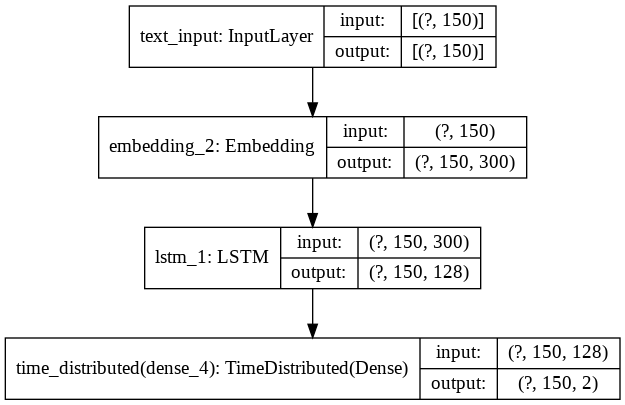

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#mak = tf.math.logical_not(tf.math.equal(f_train, 0))
#mak.shape #TensorShape([24732, 150])
#mak[0] # output :
#<tf.Tensor: shape=(150,), dtype=bool, numpy=
'''array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])>'''



'''
y_cv[0]
output:
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


mask_cv[0]
output:
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



f_cv[0] = mask_cv[0]+y_cv[0]

output:
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


h=f_cv[0] 
h[h<2]=0
h[h>0]=1
h which is y_cv[0]

output: y_cv[0]
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
 def custom_loss(real,pred):
    #print(type(real))
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #getting only non zero values which gives us the masked vector
    #print("maskb",mask.shape)
    #print("pred",pred.shape)
    
    #print("mask",mask)
    r = real.numpy() #converting the tensor to array
    r[r<2]=0 #as explained in the above cell,get the actual output vector from the total  vector which has info of masked vector and output vector
    r[r>0] = 1
    #r=r.reshape(r.shape[0],150,1)
    re = tf.convert_to_tensor(r) #convert back to tensor
    #print("real",re)
    #print("pred",pred)
    cce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none') #using sparse entropy as labels as not in one hot encoding, and reduction is none,so it return loss for each input word
    l = cce(re,pred) #calculate the loss
    #print("lossb",l)
    mask = tf.cast(mask, dtype=l.dtype) #make the masked vector same type as loss value
    #print("maskf",mask.shape)
    l*=mask #multiply masked tensor with loss values tensor which gives non zero loss values for only unpadded values and loss values for padded words will be zeros
    #print("loss",l)
    #print(l.shape) #(batchsize,150) #refere spare entropy tf documentation for details

    return tf.reduce_mean(l) #average the loss per batch and return it as loss for updating the weights

In [ ]:
adam=optimizers.Adam(0.001)
model.compile(loss=custom_loss, optimizer='adam',run_eagerly=True)

In [ ]:
saving  = ModelCheckpoint("/content/best_model_{loss:.4f}.h5", monitor='loss', verbose=1, save_best_only=True,save_weights_only=True, mode='auto', save_freq='epoch')
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),histogram_freq=1, write_graph=True,write_grads=True)
lr_red = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto',min_delta=0.0000001)

In [ ]:
history = model.fit(X_train_pad,f_train, epochs=10, batch_size=256,validation_data=(X_cv_pad,f_cv),callbacks=[saving,tensorboard_callback,lr_red])

Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 0.1718
Epoch 00001: loss improved from inf to 0.17179, saving model to /content/best_model_0.1718.h5
97/97 [==============================] - 57s 589ms/step - loss: 0.1718 - val_loss: 0.1681
Epoch 2/10
97/97 [==============================] - ETA: 0s - loss: 0.1620
Epoch 00002: loss improved from 0.17179 to 0.16204, saving model to /content/best_model_0.1620.h5
97/97 [==============================] - 56s 574ms/step - loss: 0.1620 - val_loss: 0.1661
Epoch 3/10
97/97 [==============================] - ETA: 0s - loss: 0.1597
Epoch 00003: loss improved from 0.16204 to 0.15969, saving model to /content/best_model_0.1597.h5
97/97 [==============================] - 56s 576ms/step - loss: 0.1597 - val_loss: 0.1625
Epoch 4/10
97/97 [==============================] - ETA: 0s - loss: 0.1411
Epoch 00004: loss improved from 0.15969 to 0.14106, saving model to /content/best_model_0.1411.h5
97/97 [==============================] - 5

In [ ]:
%load_ext tensorboard
#!rm -rf ./logs/ 

In [ ]:
%tensorboard --logdir logs/fit

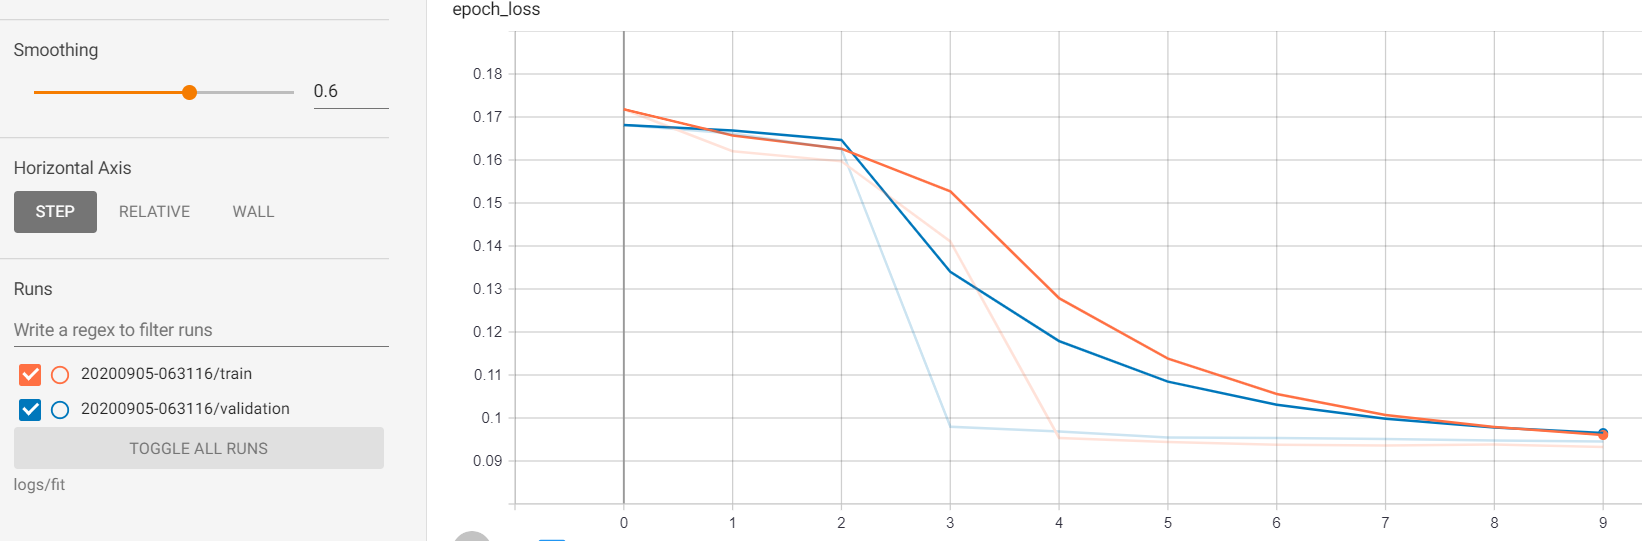

In [ ]:
from IPython.display import Image
Image('manyl.PNG')

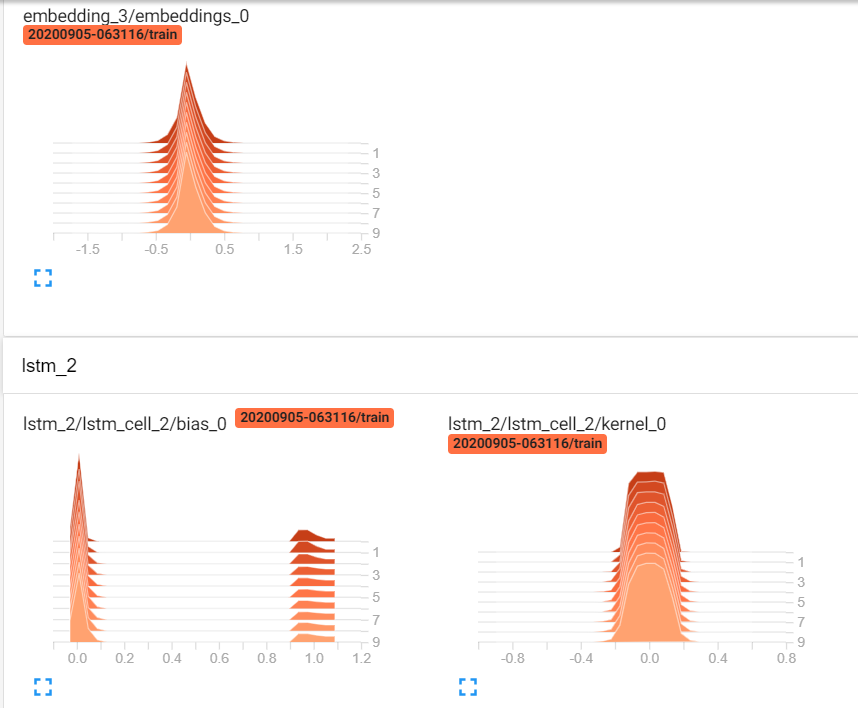

In [ ]:
Image('manye.PNG')

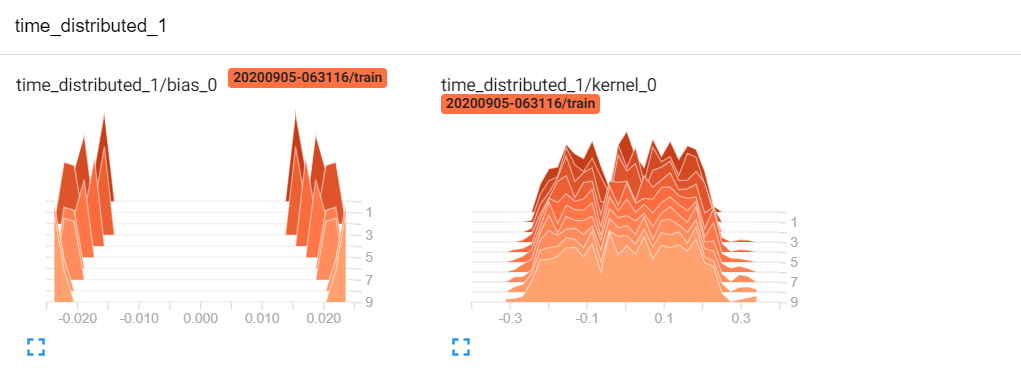

In [ ]:
Image('manyt.PNG')

**Observation:** We can see that loss is not improving significantly after some epochs,so lets stop our training here and take this as best model to make the predictions.From histogram plots,we can see that our required layers are getting trained there by infering that model is trining good enough.Lets make predictions and valuate our model.

## Predictions

Train data

In [ ]:
model.load_weights('best_model_0.0932.h5') #loading the best model 

In [ ]:
pr = model.predict(X_train_pad) #predict train values
pr.shape #for each word,we will have two probabilities whether belongs to  0 class or 1 class

(24732, 150, 2)

In [ ]:
p_t=[]
for i in pr:
  p=[]
  for j in i:
    p.append(np.argmax(j)) #predict the label using maximum of both probabilities 
  p_t.append(p)
pt = np.array(p_t)
pt.shape

(24732, 150)

In [ ]:
t = pt*X_train_pad #multiply the predicted values with tokenized padded vectors which has indexes,so that we get the output indexes of each sentence,those which give output as 1 only will be given index
#else will be zero 
#ex: actual words labels padded to 6 words: [0,0,0,1,1,1] ; predicted labels : [0,0,0,1,0,1] and x_train pad :[0,0,0,125,25,12] output words will be : [0,0,0,125,0,12]
#now we take this output words and get back the words using tokenizer vocubulary
t.shape

(24732, 150)

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    #print(list_of_indices)
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return (words)

In [ ]:
train_pred=[]
for i in t: #for each sentence output predictions
  x = [j for j in i if j != 0]
  # Creating texts 
  my_texts = sequence_to_text(x) #get the charcters from the indexes
  my = ''.join(my_texts) #join them to form sentence
  train_pred.append(my)

In [ ]:
x_train['predictions'] = train_pred #predictions

In [ ]:
x_train.head()

,textID,text,selected_text,sentiment,predictions
21498,519c8c1740,"neutral Ok, shortened urls are fine and all bu...","Ok, shortened urls are fine and all but, pleas...",neutral,"ok, shortened urls are fine and all but, pleas..."
22094,c225e9d712,"neutral hows the peas doin? if you meet them,...","hows the peas doin? if you meet them, tell the...",neutral,"hows the peas doin? if you meet them, tell the..."
9730,4e001c7f10,neutral Ready for Mother`s Day? http://tinyurl...,Ready for Mother`s Day? http://tinyurl.com/dcgeyv,neutral,ready for mother`s day? http://tinyurl.com/dcgeyv
25442,041fb3610e,neutral do you really smoke???,do you really smoke???,neutral,do you really smoke???
2997,146503eb1e,negative agh! freaking out about going to Wale...,freaking out,negative,


In [ ]:
js=0
for i in range(x_train.shape[0]):
  try: #leaving out the null valued row in train input
    js = js + jaccard(x_train.iloc[i,2],x_train.iloc[i,4])
  except:
    print(i)
print("final jaccard score for train data:",js/(x_train.shape[0]))

8609
final jaccard score for train data: 0.39321071156980986


cv data

In [ ]:
prc = model.predict(X_cv_pad)
prc.shape

(2749, 150, 2)

In [ ]:
p_v=[]
for i in prc:
  p=[]
  for j in i:
    p.append(np.argmax(j))
  p_v.append(p)
pv = np.array(p_v)
pv.shape

(2749, 150)

In [ ]:
v = pv*X_cv_pad
v.shape

(2749, 150)

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    #print(list_of_indices)
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return (words)

In [ ]:
cv_pred=[]
for i in v:
  x = [j for j in i if j != 0]
  # Creating texts 
  my_texts = sequence_to_text(x)
  my = ''.join(my_texts)
  cv_pred.append(my)

In [ ]:
x_cv['predictions'] = cv_pred

In [ ]:
js=0
for i in range(x_cv.shape[0]):
    js = js + jaccard(x_cv.iloc[i,2],cv_pred[i])
print("final jaccard score for train data:",js/(x_cv.shape[0]))

final jaccard score for train data: 0.3927150660880608


**Observations:**From predictions column we can see that model is predicting only neutral values and it is not at all considering about positive and negative tweets.Its like it is grouping the neutral tweets as one cluster and rest of them as other cluster.Seems like this type of model is learning lazy and giving us the naive results.I have tried changing parameters,but performance remains the same.

Many to many type of lstm model may not be suited for this respective data where the outputs does not have any pattern in positive and negative tweets.As lstm architecture is simple and we are using glove embeddings and character level tokenization,its hard to predict the phrases as single words depending on the sentiment using many - many model.for example: "he is a good boy",we have to predict:"good boy",now if we use q&a type model,it will be easy for the model to extract positive phrases from sentence rather than predicting each word using many-many type model,because in this, we have to predict words like "boy" which is neither positive nor negative.we will be having lot of words like this in positive or negative sentiments which are neither positive nor negative,so it will be tough for this type of model to predict words.

This type of model will be suitable if:
1. we are solving NER based problems,where,irrespective of the sentence sentiment,every word will behave the same in all the sentences..like "boy" will be noun in all the sentences. 

OR
2. If we want to extract only positive words from sentence not the positive phrases like in this problem.


#Summary

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Hyperparameters","train score","test score"]
x.add_row(["Naive model","--", 0.58,0.57])
x.add_row(["Siamese network","to be modified", 0,0])
x.add_row(["LSTM-word level","glove embeddings,adam,lr=0.001,batch_size=256", 0.46,0.43])
x.add_row(["LSTM-character level","glove embeddings,adam,lr=0.001,batch_size=512",0.58,0.58])

x.add_row(["Roberta-fine tuning","roberta embeddings,adam,lr=1e-5,batch_size=32", 0.68,0.70])
x.add_row(["Many-Many-LSTM-characater level","glove embeddings,adam,lr=1e-3,batch_size=256", 0.40,0.39])

print(x)

+---------------------------------+-----------------------------------------------+-------------+------------+
|              Model              |                Hyperparameters                | train score | test score |
+---------------------------------+-----------------------------------------------+-------------+------------+
|           Naive model           |                       --                      |     0.58    |    0.57    |
|         Siamese network         |                 to be modified                |      0      |     0      |
|         LSTM-word level         | glove embeddings,adam,lr=0.001,batch_size=256 |     0.46    |    0.43    |
|       LSTM-character level      | glove embeddings,adam,lr=0.001,batch_size=512 |     0.58    |    0.58    |
|       Roberta-fine tuning       | roberta embeddings,adam,lr=1e-5,batch_size=32 |     0.68    |    0.7     |
| Many-Many-LSTM-characater level |  glove embeddings,adam,lr=1e-3,batch_size=256 |     0.4     |    0.39    |
+

## Final Observations:



*   We can see that there is importance of noise(special characters and meaningless words) in predicting the final data,so better handling of the noise may yield the best result.But this will be acceptable as far as kaggle problem is concerned,because all they want is best score on data.But in real world, we have lot of things like business constraints,interpretability to care of.So,taking the real world constraints into account,it will be meaningless to take only noise and try to find patterns in that and add those patterns to final model to get the best score.

*    Also simple architectures using lstm are not good at taking the contextual meanings base on the sentiment and given sentences.
*    Tokenization and type of embeddings we are using are also to be taken care of because we have to train the model without cleaning.So better tokenizations and embeddings like bert may yield good results.
*    we have to experiment with all these tokenizations and embeddings trying from the basic architecture to complex architectures.LSTM model may work if we design an architecture based on further indepth analysis of data like how start tokens are distributed based on the sentiment and length of sentence in each sentiment...etc.If we have time we can try building new architectures.But its better to use already available complex models like bert and try to get good results from them.

*   So based on above inference,we can choose roberta as our final model for real world solving,which handles the noise as well.



#FURTHER APPROACHES:

*  We can try BERT NER and model this as predicting tokens but using BERT Q&A should beat BERT NER because finding clauses is different than finding words. For example, if i say "Today was a good day". The word "day" is neither positive or negative, but as a clause "good day" is positive. we have to check and pick the best model.

*  Modelling this as token classification (similar to NER):we can get the bert tokenization and embeddings and using lstm network try to predict each token present in the sentence,but that would use outer dense layers with fixed number of neurons(maximum sequence length),so we cant predict test samples of length more than that.

*   we have pick our best model based on the real world constraints like memory,latency,cost,interpretability...